Load the phenotypic file derived from the HBN dataset and sort the participants by their index in ascending order to match the order of the timeseries of each participant. The participants that are read have been thresholded for head motion with a root-mean-square framewise displacement (RMS) less than 0.20 mm.

In [1]:
import os
import glob
import os.path as path
import pandas as pd
import numpy as np
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt


/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Read the timeseries of the participants for REST1 and REST2 and compute the FC matrices for each participant for the two runs. The FC matrices are computed using the Pearson's correlation coefficient. Here, we retain only the non-zero ROI values instead of the entire list of ROIs (k=268) derived from the Shen parcellation. A zero ROI value would indicate lack of spatial coverage at that specific region or parcel. The number of edges should be equal to ((ROI * ROI) - ROI) / 2. Hence, if we have 268 ROIs, the total number of edges should be 35778.

In [90]:
rs_datapath = '/Users/jivesh/Downloads/HBNTS239/*_HBN_268Parcels_rest_run_1.txt'
mv_datapath = '/Users/jivesh/Downloads/HBNTS239/*_HBN_268Parcels_rest_run_2.txt'

#rs_datapath = '/Users/jivesh/Downloads/UPSM_high_motion_Shen_268/*_UPSM_Shen_268Parcels_rest_session_2.txt'
#mv_datapath = '/Users/jivesh/Downloads/UPSM_high_motion_Shen_268/*_UPSM_Shen_268Parcels_rest_session_1.txt'

rsfilename_list = np.sort(glob.glob(rs_datapath))
mvfilename_list = np.sort(glob.glob(mv_datapath))

rs_non_zero_roi = []
rsfMRI_timeseries = []
rsfMRI_timeseries_2d = []
rsfMRI_timeseries_corr = []

mv_non_zero_roi = []
mvfMRI_timeseries = []
mvfMRI_timeseries_2d = []
mvfMRI_timeseries_corr = []

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []
mvall_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []

for rsfilename in rsfilename_list:

    rs_corr_shen = np.transpose(np.loadtxt(rsfilename))
    rsfMRI_timeseries.append(rs_corr_shen)
    rs_non_zero = np.where(np.any(rs_corr_shen == 0, axis = 1))
    rs_non_zero_roi = np.concatenate((rs_non_zero_roi, rs_non_zero), axis = None)

rsfMRI_timeseries_to_array = np.asarray(rsfMRI_timeseries)

for mvfilename in mvfilename_list:

    mv_corr_shen = np.transpose(np.loadtxt(mvfilename))
    mvfMRI_timeseries.append(mv_corr_shen)
    mv_non_zero = np.where(np.any(mv_corr_shen == 0, axis = 1))
    mv_non_zero_roi = np.concatenate((mv_non_zero_roi, mv_non_zero), axis = None)

mvfMRI_timeseries_to_array = np.asarray(mvfMRI_timeseries)

all_indices_s1_s2 = np.concatenate((rs_non_zero_roi, mv_non_zero_roi), axis = None)
find_unique_indices = np.unique(all_indices_s1_s2)
find_unique_indices_int = find_unique_indices.astype(int)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for REST1
rsfMRI_nonzero_timeseries = np.delete(rsfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)
print(rsfMRI_nonzero_timeseries.shape)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for REST2
mvfMRI_nonzero_timeseries = np.delete(mvfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)
print(mvfMRI_nonzero_timeseries.shape)

for rs_sub in range(0, len(rsfilename_list)):

    rsfMRI_timeseries_2d = rsfMRI_nonzero_timeseries[rs_sub, :, :].copy()
    #compute Pearson's correlation coefficient for REST1
    rsfMRI_corr = np.corrcoef(rsfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for REST1
    rsfMRI_corr_shen = rsfMRI_corr.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr[arange_rsfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    rsfMRI_timeseries_corr.append(trunc_rsfMRI_corr_shen)

trunc_rsfMRI_corr_to_array = np.asarray(rsfMRI_timeseries_corr)
FC_REST1 = trunc_rsfMRI_corr_to_array
print(FC_REST1.shape)

for mv_sub in range(0, len(mvfilename_list)):

    mvfMRI_timeseries_2d = mvfMRI_nonzero_timeseries[mv_sub, :, :].copy()
    #compute Pearson's correlation coefficient for REST2
    mvfMRI_corr = np.corrcoef(mvfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for REST2
    mvfMRI_corr_shen = mvfMRI_corr.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr[arange_mvfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    mvfMRI_timeseries_corr.append(trunc_mvfMRI_corr_shen)

trunc_mvfMRI_corr_to_array = np.asarray(mvfMRI_timeseries_corr)
FC_REST2 = trunc_mvfMRI_corr_to_array
print(FC_REST2.shape)


(239, 266, 375)
(239, 266, 375)
(239, 35245)
(239, 35245)


In [97]:
behav_datapath = pd.read_csv('/Users/jivesh/Downloads/HBN_N239_info.csv', index_col = 'SUBID')
behav_df = behav_datapath.sort_index().copy()
behav_df


,GENDER,SEX,AGE,CBCL_TOTAL_T,CBCL_EXT_T,CBCL_INT_T,SRS_TOTAL_T,REST1_FD,REST2_FD
SUBID,,,,,,,,,
sub-NDARAB458VK9,Male,0,12.84,56,50,50,48,0.0977,0.1053
sub-NDARAC331VEH,Male,0,14.17,67,69,68,53,0.0388,0.0415
sub-NDARAC350BZ0,Male,0,12.92,66,64,70,58,0.0889,0.0910
sub-NDARAG115LZP,Female,1,14.17,45,44,50,49,0.0872,0.0762
sub-NDARAH976BND,Female,1,14.35,79,75,77,78,0.1192,0.0898
...,...,...,...,...,...,...,...,...,...
sub-NDARZT940RZG,Female,1,14.64,51,44,56,40,0.0995,0.0725
sub-NDARZT957CWG,Male,0,16.03,71,66,71,86,0.0763,0.0745
sub-NDARZW873DN3,Female,1,13.44,58,49,68,65,0.0844,0.0733


In [637]:
behav_datapath = pd.read_csv('/Users/jivesh/Downloads/HBN255_info.csv', index_col = 'SUBID')
behav_df = behav_datapath.sort_index().query('REST1_FD <= 0.20 & REST2_FD <= 0.20').copy()
behav_df.head(n = 10)
behav_df


,GENDER,SEX,AGE,CBCL_TOTAL_T,CBCL_EXT_T,CBCL_INT_T,SRS_TOTAL_T,REST1_FD,REST2_FD
SUBID,,,,,,,,,
sub-NDARAA504CRN,Female,1,9.17,54,53,56,55,0.1119,0.1473
sub-NDARAB458VK9,Male,0,12.84,56,50,50,48,0.0977,0.1053
sub-NDARAC331VEH,Male,0,14.17,67,69,68,53,0.0388,0.0415
sub-NDARAC350BZ0,Male,0,12.92,66,64,70,58,0.0889,0.0910
sub-NDARAF535XK6,Female,1,13.12,60,52,60,67,0.1423,0.1645
...,...,...,...,...,...,...,...,...,...
sub-NDARZT940RZG,Female,1,14.64,51,44,56,40,0.0995,0.0725
sub-NDARZT957CWG,Male,0,16.03,71,66,71,86,0.0763,0.0745
sub-NDARZW873DN3,Female,1,13.44,58,49,68,65,0.0844,0.0733


In [22]:
behav_datapath = pd.read_csv('/Users/jivesh/Downloads/HBN379_info.csv', index_col = 'SUBID')
behav_df = behav_datapath.sort_index().copy()
behav_df.head(n = 10)
behav_df


,GENDER,SEX,AGE,CBCL_TOTAL_T,CBCL_EXT_T,CBCL_INT_T,SRS_TOTAL_T,REST1_FD,REST2_FD
SUBID,,,,,,,,,
sub-NDARAA504CRN,Female,1,9.17,54,53,56,55,0.1119,0.1473
sub-NDARAB458VK9,Male,0,12.84,56,50,50,48,0.0977,0.1053
sub-NDARAC331VEH,Male,0,14.17,67,69,68,53,0.0388,0.0415
sub-NDARAC350BZ0,Male,0,12.92,66,64,70,58,0.0889,0.0910
sub-NDARAE877NER,Female,1,11.34,67,49,71,70,0.1379,0.2521
...,...,...,...,...,...,...,...,...,...
sub-NDARZT957CWG,Male,0,16.03,71,66,71,86,0.0763,0.0745
sub-NDARZV749GAP,Male,0,8.10,54,56,58,43,0.1839,0.6682
sub-NDARZW873DN3,Female,1,13.44,58,49,68,65,0.0844,0.0733


Compute the edge-level partial spearman rank correlation between FC and phenotypic data (e.g., AGE, CBCL, SRS) while treating sex and head motion (RMSFD) as covariates. This is to find out which edge shares a significant relationship with behaviour. After obtaining the correlation and its significance for each edge, it is important to correct for multiple comparisons (i.e., we need to correct the p values for the number of edges) using FDR correction as it is less conservative than Bonferroni. 

In [98]:
model_pval = []
model_coef = []

for edge in range(0, FC_REST1.shape[1]):
    
    behav_df['FC'] = FC_REST1[:, edge]
    model = pg.partial_corr(data = behav_df, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_pval.append(model['p-val'])
    model_coef.append(model['r'])
    

We can also find out how many edges survive multiple comparisons (p < 0.05 FDR). After finding the edges that multiple comparison corrections, we select ONE edge that shares the highest correlation strength with the phenotypic data (i.e., highest R value) to continue with the analyses.

In [99]:
import statsmodels.stats.multitest as mc

corr_pval = mc.multipletests(np.array(model_pval).flatten(), alpha = 0.05, method = 'fdr_bh')
pcorr_indices = np.where(corr_pval[1] <= 0.05)
np.array(pcorr_indices).shape[1]


616

In [100]:
REST1_coef = np.array(np.take(model_coef, pcorr_indices)).flatten()
REST1_pval = np.array(np.take(model_pval, pcorr_indices)).flatten()
max_corr_edge = REST1_coef.argmax()

best_edge = np.array(np.where(model_coef == REST1_coef[max_corr_edge])).squeeze()[0]
best_edge


34121

In order to the generalise the performance of bagging, it is important to repeat the analyses across different edges that survive FDR correction. Instead of selecting the edge that shares the highest correlation strength, let us select the top 10 edges on the basis of their R values. Given that we have already applied bagging to the top edge, we can select the nine remaining edges.

In [1284]:
top_edges = (-REST1_coef).argsort()[1:10]
top_edges = np.array(np.where(model_coef == REST1_coef[top_edges])).squeeze()[0]
top_edges


array([ 1383,  3429,  3760, 10516, 12045, 14989, 15054, 15214, 19469])

You can also have a look at the R values that correspond to the correlation strengths of the nine edges that we have chosen as follows:

In [1285]:
top_coefs = np.array(model_coef)[top_edges]
top_coefs


array([[0.2933779 ],
       [0.28387195],
       [0.28531267],
       [0.27603177],
       [0.30065092],
       [0.31225205],
       [0.28681598],
       [0.30022351],
       [0.30191464]])

Now that we have the index of the "best" edge, i.e., the edge that shares the highest correlation strength, we can backtrack to find the pair of ROIs that this edge is connected to. Instead of performing the analyses with all the non-zero ROIs, we can perform the computations with ONLY the pair of ROIs which will accelerate the analyses by a great fold. Using the pair of ROIs will take a few minutes to run whereas the complete list of non-zero ROIs will take some hours to finish.

In [101]:
best_edge

34121

In [102]:
numROI = rsfMRI_nonzero_timeseries.shape[1]

TEMP_A = np.arange(numROI * numROI).reshape(numROI, numROI)
TEMP_A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(TEMP_A, 1)

TEMP_B = TEMP_A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(TEMP_A2 == TEMP_B[best_edge]) 
#ROI_dimx = np.where(TEMP_A2 == TEMP_B[top_edges][8])
rsfMRI_bestroi_nonzero_timeseries = np.take(rsfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_timeseries = np.take(mvfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()

print(rsfMRI_bestroi_nonzero_timeseries.shape)
print(mvfMRI_bestroi_nonzero_timeseries.shape)


(239, 2, 375)
(239, 2, 375)


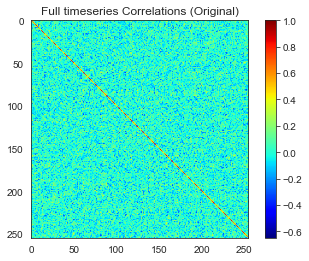

In [148]:
rsfMRI_bestroi_nonzero_timeseries_ROI1 = rsfMRI_bestroi_nonzero_timeseries[:,0,:]
orig_correlations = np.corrcoef(rsfMRI_bestroi_nonzero_timeseries_ROI1)
plt.imshow(orig_correlations, cmap = 'jet')
mean_original_corrtimeseries = orig_correlations[np.tril_indices(rsfMRI_bestroi_nonzero_timeseries_ROI1.shape[0], k = -1)].mean()
plt.title('Full timeseries Correlations (Original)')
plt.colorbar()


In [151]:
mean_original_corrtimeseries = np.abs(orig_correlations[np.tril_indices(rsfMRI_bestroi_nonzero_timeseries_ROI1.shape[0], k = -1)]).mean()
mean_original_corrtimeseries

0.11929424636561747

#### Standard Approach

We can proceed to compute the relationship between FC and behaviour as a function of sample size (N) using the <u>full timeseries</u> of the participants. We refer to this as the **standard approach** where we bootstrap N from a subset of participants (e.g., N=20,40,60,100...) across 500 epochs for each run (i.e., REST1, REST2).  

In [477]:
subjects = 255
epochs = 500

all_rssamples = []
all_mvsamples = []

edges = (rsfMRI_bestroi_nonzero_timeseries.shape[1]**2 - rsfMRI_bestroi_nonzero_timeseries.shape[1]) // 2

bootstrap_REST1_corr = np.zeros((epochs, subjects))
bootstrap_REST2_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    for sub_s1 in range(rsbootstrap_samples.shape[0]):
        
        rsbootstrap_timeseries_2d = rsbootstrap_samples[sub_s1, :, :].copy()
        rsbootstrap_corr_matrix = np.corrcoef(rsbootstrap_timeseries_2d)
        
        rsbootstrap_corr_shen = rsbootstrap_corr_matrix.shape[0]
        arange_rsbootstrap_corr, diag = np.triu_indices(rsbootstrap_corr_shen, 1)
        trunc_rsbootstrap_corr = rsbootstrap_corr_matrix[arange_rsbootstrap_corr, diag]
        bootstrap_REST1_corr[epoch, sub_s1] = trunc_rsbootstrap_corr
        
for epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    for sub_s2 in range(mvbootstrap_samples.shape[0]):
        
        mvbootstrap_timeseries_2d = mvbootstrap_samples[sub_s2, :, :].copy()
        mvbootstrap_corr_matrix = np.corrcoef(mvbootstrap_timeseries_2d)
        
        mvbootstrap_corr_shen = mvbootstrap_corr_matrix.shape[0]
        arange_mvbootstrap_corr, diag = np.triu_indices(mvbootstrap_corr_shen, 1)
        trunc_mvbootstrap_corr = mvbootstrap_corr_matrix[arange_mvbootstrap_corr, diag]
        bootstrap_REST2_corr[epoch, sub_s2] = trunc_mvbootstrap_corr

print(bootstrap_REST1_corr.shape)
print(bootstrap_REST2_corr.shape)


(500, 255)
(500, 255)


We then use the bootstrapped FC matrices and compute the relationships with the phenotypic data for each epoch. We retain the correlation coefficient and significance of the relationship for each epoch in order to help us plot these as a function of N. Further, we compute and plot the following in a singe graph: (I) minimum coefficient; (II) maximum coefficient; (III) mean coefficient; (IV) lower 95% CI; and (V) upper 95% CI.


In [478]:
model_standard_pval = []
model_standard_coef = []

for epoch in range(epochs):
    
    behav2 = behav_df[['AGE', 'SEX', 'REST1_FD']]
    behav2 = pd.DataFrame(np.take(np.array(behav2), all_rssamples[epoch], axis = 0))
    behav2.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav2['FC'] = bootstrap_REST1_corr[epoch, :]
    
    standard_model = pg.partial_corr(data = behav2, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_standard_pval.append(standard_model['p-val'])
    model_standard_coef.append(standard_model['r'])
    

In [479]:
model_standard_pval = np.array(model_standard_pval)
model_standard_coef = np.array(model_standard_coef)

min_coef = model_standard_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_standard_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_standard_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_standard_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_standard_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.2976153601204261
max coef:0.2976153601204261
mean coef:0.2976153601204262
lower ci:0.2976153601204261
upper ci:0.2976153601204261


In [692]:
standard_approach_REST = pd.read_csv('/Users/jivesh/Downloads/testtttt.csv')
standard_approach_REST.head(n = 10)


,SAMPLES,SIZE,MINTR,FD,METHOD,COEFFICIENTS
0,20,255,60,0.2,MIN,-0.380
1,40,255,60,0.2,MIN,-0.240
2,60,255,60,0.2,MIN,-0.095
3,80,255,60,0.2,MIN,-0.014
4,100,255,60,0.2,MIN,0.100
5,120,255,60,0.2,MIN,0.097
6,140,255,60,0.2,MIN,0.140
7,160,255,60,0.2,MIN,0.150
8,180,255,60,0.2,MIN,0.190
9,200,255,60,0.2,MIN,0.190


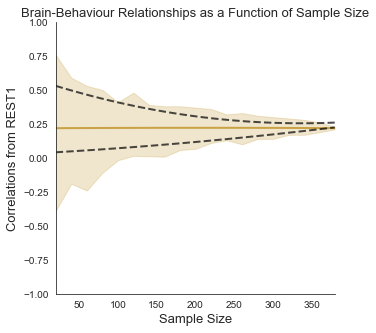

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

plt.xlim(standard_approach_REST["SAMPLES"].min(), standard_approach_REST["SAMPLES"].max())
plt.xlim(20, 379)

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(standard_approach_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["darkgoldenrod", "darkgoldenrod", "darkgoldenrod", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = standard_approach_REST.loc[standard_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(standard_approach_REST["SAMPLES"].unique(), standard_approach_REST[standard_approach_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 standard_approach_REST[standard_approach_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color='darkgoldenrod', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST1", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


#### Bagging Approach

The bagging approach, also known as bootstrap aggregation, is a way to randomly select a sample of the training data with replacement. Here, we employ this approach to randomly select subsamples of the "best" timepoints in the fMRI timeseries for REST1 and REST2, i.e., we select subsets of the least contaminated timepoints in the timeseries. In order to identify the contaminated timepoints, we follow the scrubbing procedure from Power et al. (2014) such that a contaminated timepoint (T) is identified if its RMSFD exceeds a predefined threshold. After identifying T, we remove the preceding timepoint (T-1) in addition to the two succeeding timepoints (T+1, T+2) in the timeseries. Each participant will have a scrubbed timeseries which may be of different size from the other participants.

In [104]:
behav_datapath = pd.read_csv('/Users/jivesh/Downloads/HBN_N239_info.csv', index_col = 'SUBID')
behav_df = behav_datapath.sort_index().copy()
#behav_df = behav_datapath.sort_index().query('REST1_FD <= 0.20 & REST2_FD <= 0.20').copy()
#behav_df.head(n = 10)
behav_df


,GENDER,SEX,AGE,CBCL_TOTAL_T,CBCL_EXT_T,CBCL_INT_T,SRS_TOTAL_T,REST1_FD,REST2_FD
SUBID,,,,,,,,,
sub-NDARAB458VK9,Male,0,12.84,56,50,50,48,0.0977,0.1053
sub-NDARAC331VEH,Male,0,14.17,67,69,68,53,0.0388,0.0415
sub-NDARAC350BZ0,Male,0,12.92,66,64,70,58,0.0889,0.0910
sub-NDARAG115LZP,Female,1,14.17,45,44,50,49,0.0872,0.0762
sub-NDARAH976BND,Female,1,14.35,79,75,77,78,0.1192,0.0898
...,...,...,...,...,...,...,...,...,...
sub-NDARZT940RZG,Female,1,14.64,51,44,56,40,0.0995,0.0725
sub-NDARZT957CWG,Male,0,16.03,71,66,71,86,0.0763,0.0745
sub-NDARZW873DN3,Female,1,13.44,58,49,68,65,0.0844,0.0733


In [108]:
rs_motion_param_datapath = '/Users/jivesh/Downloads/HBN_MOTION_N239/*_task-rest_run-1_bold_mcf.nii.gz_rel.rms'
mv_motion_param_datapath = '/Users/jivesh/Downloads/HBN_MOTION_N239/*_task-rest_run-2_bold_mcf.nii.gz_rel.rms'

#rs_motion_param_datapath = '/Users/jivesh/Downloads/UPSM_high_motion_params/*_session_2_rest_1_rest_mcf.nii.gz_rel.rms'
#mv_motion_param_datapath = '/Users/jivesh/Downloads/UPSM_high_motion_params/*_session_1_rest_1_rest_mcf.nii.gz_rel.rms'

rsfilename_motion_param_list = np.sort(glob.glob(rs_motion_param_datapath))
mvfilename_motion_param_list = np.sort(glob.glob(mv_motion_param_datapath))

#select head motion threshold to identify contaminated timepoints
threshold = 0.20

#select minimum amount of timepoints to be retained after identifying contaminated timepoints
minTP = 200

#select number of bootstrapped timepoints from the best timepoints
TP = 60

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []


In [109]:
for rsfilename in range(rsfMRI_nonzero_timeseries.shape[0]):

    rmsFDs1 = np.loadtxt(rsfilename_motion_param_list[rsfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs1_thresh = np.asarray(np.where(rmsFDs1 > threshold))
    
    #find the indices of the preceding timepoints to be srubbed from the timeseries
    left_indices = rmsFDs1_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    left_nonzero_indices = left_indices[left_indices >= 0]
    
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    right_first_indices = rmsFDs1_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    right_first_in_range_indices = right_first_indices[right_first_indices < rmsFDs1.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    right_second_indices = rmsFDs1_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    right_second_in_range_indices = right_second_indices[right_second_indices < rmsFDs1.shape]
    
    all_contaminated_indices = np.concatenate((rmsFDs1_thresh, left_nonzero_indices, right_first_in_range_indices, right_second_in_range_indices), axis = None)
    unique_contaminated_indices = np.unique(all_contaminated_indices).astype(int)
    all_unique_contaminated_indices.append(unique_contaminated_indices)
    
    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_timepoints_size = rsfMRI_nonzero_timeseries.shape[2] - np.asarray(unique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints in an array
    best_timepoints_size_s1.append(best_timepoints_size)
    
    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints
    if (best_timepoints_size < minTP):
        rssubj_exclusion.append(rsfilename)


In [110]:
for mvfilename in range(mvfMRI_nonzero_timeseries.shape[0]):

    rmsFDs2 = np.loadtxt(mvfilename_motion_param_list[mvfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs2_thresh = np.asarray(np.where(rmsFDs2 > threshold))

    #find the indices of the preceding timepoints to be srubbed from the timeseries
    mvleft_indices = rmsFDs2_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    mvleft_nonzero_indices = mvleft_indices[mvleft_indices >= 0]
    
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    mvright_first_indices = rmsFDs2_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    mvright_first_in_range_indices = mvright_first_indices[mvright_first_indices < rmsFDs2.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    mvright_second_indices = rmsFDs2_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    mvright_second_in_range_indices = mvright_second_indices[mvright_second_indices < rmsFDs2.shape]

    mvall_contaminated_indices = np.concatenate((rmsFDs2_thresh, mvleft_nonzero_indices, mvright_first_in_range_indices, mvright_second_in_range_indices), axis = None)
    mvunique_contaminated_indices = np.unique(mvall_contaminated_indices).astype(int)
    mvall_unique_contaminated_indices.append(mvunique_contaminated_indices)

    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_mvtimepoints_size = mvfMRI_nonzero_timeseries.shape[2] - np.asarray(mvunique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints in an array
    best_timepoints_size_s2.append(best_mvtimepoints_size)
    
    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints
    if (best_mvtimepoints_size < minTP):
        mvsubj_exclusion.append(mvfilename)
        

In [111]:
#concatenate all subjects to be excluded from REST1 & REST2
all_subj_exclusion = np.concatenate((rssubj_exclusion, mvsubj_exclusion), axis = None)
unique_subj_exclusion = np.unique(all_subj_exclusion).astype(int)
print("Total number of participants to be excluded for REST1 & REST2:" + str(unique_subj_exclusion))

#remove the size of the best timepoints for the subjects to be excluded for REST1 & REST2
best_timepoints_s1 = np.delete(best_timepoints_size_s1, unique_subj_exclusion)
best_timepoints_s2 = np.delete(best_timepoints_size_s2, unique_subj_exclusion)

#remove the subjects to be excluded from the original 3D array for REST1 & REST2
rsfMRI_nonzero_best_timeseries = np.delete(rsfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
mvfMRI_nonzero_best_timeseries = np.delete(mvfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
print(rsfMRI_nonzero_best_timeseries.shape); print(mvfMRI_nonzero_best_timeseries.shape)

#remove all the unique contaminated indices of the subjects to be excluded for REST1 & REST2
rsbest_unique_contaminated_indices = np.delete(all_unique_contaminated_indices, unique_subj_exclusion)
mvbest_unique_contaminated_indices = np.delete(mvall_unique_contaminated_indices, unique_subj_exclusion)
print(rsbest_unique_contaminated_indices.shape); print(rsbest_unique_contaminated_indices.shape)

#retain only the pair of ROIs whose edge shares the highest R value with behaviour
rsfMRI_bestroi_nonzero_bag_timeseries = np.take(rsfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_bag_timeseries = np.take(mvfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()
print(rsfMRI_bestroi_nonzero_bag_timeseries.shape); print(mvfMRI_bestroi_nonzero_bag_timeseries.shape)


Total number of participants to be excluded for REST1 & REST2:[]
(239, 266, 375)
(239, 266, 375)
(239,)
(239,)
(239, 2, 375)
(239, 2, 375)


/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


Now we employ the bagging approach by randomly selecting subsamples of the least contaminated timepoints with replacement (i.e., a timepoint may be selected more than once) across 500 epochs. We rank the timepoints in ascending order (starting with the lowest RMSFD) and then bootstrap X amount of timepoints to compute the FC matrices for each participant and epoch. Hence, we are using the <u>bagged timeseries</u> to compute the FC matrices instead of the full timeseries.

In [741]:
subjects = 20
epochs = 500
epochsBag = 500

all_samples_REST1 = []
all_samples_REST2 = []

bootstrap_REST1_corr = np.zeros((epochsBag))
bootstrap_REST2_corr = np.zeros((epochsBag))
bootstrap_REST1 = np.zeros((epochs, subjects))
bootstrap_REST2 = np.zeros((epochs, subjects))

edges = ((rsfMRI_bestroi_nonzero_bag_timeseries.shape[1]**2 - rsfMRI_bestroi_nonzero_bag_timeseries.shape[1])) // 2

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
    bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
    all_samples_REST1.append(samples)
    
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    
    for subREST1 in range(bootstrap_samples_REST1.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST1
        subREST1_RMSFD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
     
        remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        timeseries =  np.delete(bootstrap_samples_REST1, bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 2)
        
        top_bootstrap_samples_REST1 = np.take(timeseries, find_indices_best_motion_REST1, axis = 2)
        rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, :, :]
        
        for epochB in range(epochsBag):
            
            #randomly select X amount of timepoints from the top timepoints for each participant
            bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], TP, replace = True)
            bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
            bootstrap_corr_matrix = np.corrcoef(bootstrap_timeseries)
            
            bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
            arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
            trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
            
            bootstrap_REST1_corr[epochB] = trunc_bootstrap_corr
            
        mean_bootstrap_REST1_corr = np.mean(bootstrap_REST1_corr)
        bootstrap_REST1[epoch, subREST1] = mean_bootstrap_REST1_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

Motion-ordered

In [145]:
subjects = 239
epochs = 500
epochsBag = 500

all_samples_REST1 = []
all_samples_REST2 = []

bootstrap_REST1_corr = np.zeros((epochsBag))
bootstrap_REST2_corr = np.zeros((epochsBag))
bootstrap_REST1 = np.zeros((epochs, subjects))
bootstrap_REST2 = np.zeros((epochs, subjects))

edges = ((rsfMRI_bestroi_nonzero_bag_timeseries.shape[1]**2 - rsfMRI_bestroi_nonzero_bag_timeseries.shape[1])) // 2

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
    bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
    all_samples_REST1.append(samples)
    
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    
    for subREST1 in range(bootstrap_samples_REST1.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST1
        subREST1_RMSFD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
     
        remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        timeseries =  np.delete(bootstrap_samples_REST1, bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 2)
        
        top_bootstrap_samples_REST1 = np.take(timeseries, find_indices_best_motion_REST1, axis = 2)
        rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, :, :]
        
        #for epochB in range(epochsBag):
            
            #randomly select X amount of timepoints from the top timepoints for each participant
            #bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], TP, replace = True)
            #bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
        bootstrap_corr_matrix = np.corrcoef(rsfMRI_bootstrap_timeseries_2d)
        bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
        arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
        trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
            
        #bootstrap_REST1_corr[epochB] = trunc_bootstrap_corr
        #mean_bootstrap_REST1_corr = np.mean(bootstrap_REST1_corr)
        bootstrap_REST1[epoch, subREST1] = trunc_bootstrap_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

In [146]:
model_bagging_pval = []
model_bagging_coef = []

behav_bag = behav_df[['AGE', 'SEX', 'REST1_FD']]
behav_bag = pd.DataFrame(np.delete(np.array(behav_bag), unique_subj_exclusion, axis = 0))

for epoch in range(epochs):
    
    behav_bag_samples = pd.DataFrame(np.take(np.array(behav_bag), all_samples_REST1[epoch], axis = 0))
    behav_bag_samples.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav_bag_samples['FC'] = bootstrap_REST1[epoch, :]
    
    bagging_model = pg.partial_corr(data = behav_bag_samples, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_bagging_pval.append(bagging_model['p-val'])
    model_bagging_coef.append(bagging_model['r'])
    

In [147]:
model_bagging_pval = np.array(model_bagging_pval)
model_bagging_coef = np.array(model_bagging_coef)

min_coef = model_bagging_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_bagging_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_bagging_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_bagging_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_bagging_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.37658837593614847
max coef:0.37658837593614847
mean coef:0.37658837593614847
lower ci:0.37658837593614847
upper ci:0.37658837593614847


### Getting timeseries from bagging

In [163]:
epochsBag = 1
bootstrap_REST1_TP = np.zeros((epochsBag, TP))
all_bootstrap_timeseries = np.zeros((255, TP))

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

#samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
#bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
#all_samples_REST1.append(samples)
    
#bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
#remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    
for subREST1 in range(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0]):
    
    #find the top X least contaminated timepoints for each participant for REST1
    subREST1_RMSFD = remaining_motion_param_REST1_list[subREST1]
    load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
    remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, rsbest_unique_contaminated_indices[subREST1])
    find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
    top_bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, find_indices_best_motion_REST1, axis = 2)
    rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, 0, :]
    
    for epochB in range(epochsBag):
        
        #randomly select X amount of timepoints from the top timepoints for each participant
        bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[0], TP, replace = True)
        bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample)
        
        bootstrap_REST1_TP[epochB, :] = bootstrap_timeseries
    
    mean_bootstrap_REST1_TP = np.mean(bootstrap_REST1_TP, axis = 0)
    all_bootstrap_timeseries[subREST1, :] = mean_bootstrap_REST1_TP


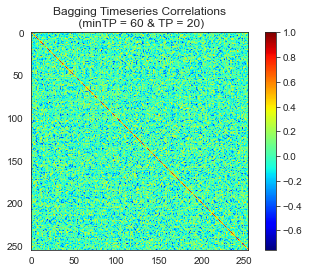

In [161]:
all_bootstrap_timeseries_2d = np.array(all_bootstrap_timeseries)
bootstrap_minTP_correlations = np.corrcoef(all_bootstrap_timeseries_2d)
plt.imshow(bootstrap_minTP_correlations, cmap = 'jet')
plt.title('Bagging Timeseries Correlations\n (minTP = 60 & TP = 20)')
plt.colorbar()


In [162]:
mean_bootstrap_corrtimeseries = np.abs(bootstrap_minTP_correlations[np.tril_indices(all_bootstrap_timeseries_2d.shape[0], k = -1)]).mean()
mean_bootstrap_corrtimeseries


0.18574375113389568

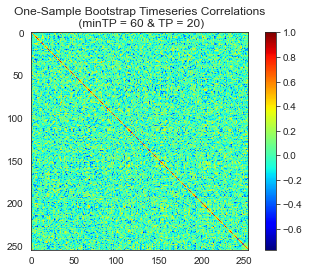

In [164]:
one_sample_bootstrap_timeseries_2d = np.array(all_bootstrap_timeseries)
one_sample_bootstrap_minTP_correlations = np.corrcoef(one_sample_bootstrap_timeseries_2d)
plt.imshow(one_sample_bootstrap_minTP_correlations, cmap = 'jet')
plt.title('One-Sample Bootstrap Timeseries Correlations\n (minTP = 60 & TP = 20)')
plt.colorbar()


In [166]:
mean_one_sample_bootstrap_corrtimeseries = np.abs(one_sample_bootstrap_minTP_correlations[np.tril_indices(one_sample_bootstrap_timeseries_2d.shape[0], k = -1)]).mean()
mean_one_sample_bootstrap_corrtimeseries


0.18583138612459618

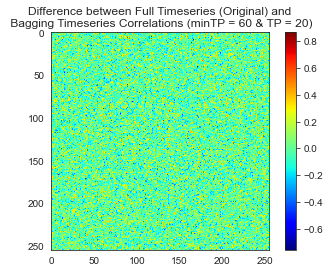

In [177]:
diff_bagging_orig = orig_correlations-bootstrap_minTP_correlations
plt.imshow(diff_ordered_orig, cmap = 'jet')
plt.title('Difference between Full Timeseries (Original) and\n Bagging Timeseries Correlations (minTP = 60 & TP = 20)')
plt.colorbar()


In [176]:
np.abs(diff_bagging_orig[np.tril_indices(diff_bagging_orig.shape[0], k = -1)]).mean()


0.219556059266631

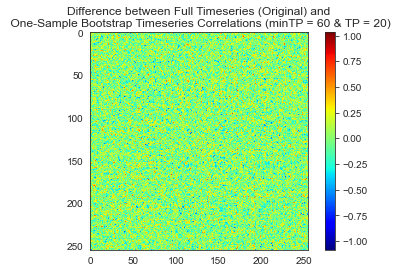

In [180]:
diff_onesample_orig = orig_correlations-one_sample_bootstrap_minTP_correlations
plt.imshow(diff_onesample_orig, cmap = 'jet')
plt.title('Difference between Full Timeseries (Original) and\n One-Sample Bootstrap Timeseries Correlations (minTP = 60 & TP = 20)')
plt.colorbar()


In [181]:
np.abs(diff_onesample_orig[np.tril_indices(diff_onesample_orig.shape[0], k = -1)]).mean()


0.2192799668456085

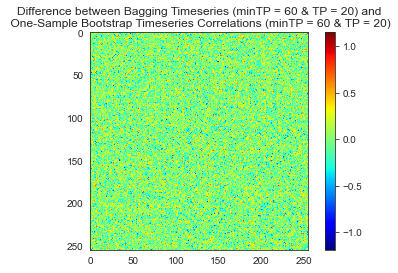

In [186]:
diff_bagging_onesample = bootstrap_minTP_correlations-one_sample_bootstrap_minTP_correlations
plt.imshow(diff_bagging_onesample, cmap = 'jet')
plt.title('Difference between Bagging Timeseries (minTP = 60 & TP = 20) and\n One-Sample Bootstrap Timeseries Correlations (minTP = 60 & TP = 20)')
plt.colorbar()


In [187]:
np.abs(diff_bagging_onesample[np.tril_indices(diff_bagging_onesample.shape[0], k = -1)]).mean()


0.2616767802068206

#### Testing Epoch for Bagging: No iteration [only minTP]

In [167]:
all_rsfMRI_ordered_timeseries_2d = []
remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

#samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
#bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
#all_samples_REST1.append(samples)
    
#bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
#remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)

for subREST1 in range(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0]):
    
    #find the top X least contaminated timepoints for each participant for REST1
    subREST1_RMSFD = remaining_motion_param_REST1_list[subREST1]
    load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
    remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, rsbest_unique_contaminated_indices[subREST1])
    find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
    top_bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, find_indices_best_motion_REST1, axis = 2)
    rsfMRI_ordered_timeseries_2d = top_bootstrap_samples_REST1[subREST1, 0, :]
    all_rsfMRI_ordered_timeseries_2d.append(rsfMRI_ordered_timeseries_2d)
    
    #randomly select X amount of timepoints from the top timepoints for each participant
    #bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], TP, replace = True)
    #bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
        

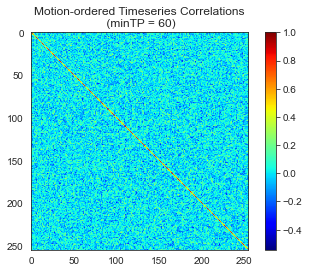

In [170]:
all_rsfMRI_ordered_timeseries_minTP_2d = np.array(all_rsfMRI_ordered_timeseries_2d)
motion_ordered_correlations = np.corrcoef(all_rsfMRI_ordered_timeseries_minTP_2d)
plt.imshow(motion_ordered_correlations, cmap = 'jet')
plt.title('Motion-ordered Timeseries Correlations\n (minTP = 60)')
plt.colorbar()


In [171]:
mean_motion_ordered_corrtimeseries = np.abs(motion_ordered_correlations[np.tril_indices(all_rsfMRI_ordered_timeseries_minTP_2d.shape[0], k = -1)]).mean()
mean_motion_ordered_corrtimeseries


0.10406433214416622

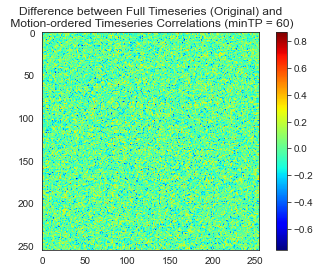

In [182]:
diff_ordered_orig = orig_correlations-motion_ordered_correlations
plt.imshow(diff_ordered_orig, cmap = 'jet')
plt.title('Difference between Full Timeseries (Original) and\n Motion-ordered Timeseries Correlations (minTP = 60)')
plt.colorbar()


In [183]:
np.abs(diff_ordered_orig[np.tril_indices(diff_ordered_orig.shape[0], k = -1)]).mean()

0.15718201615772262

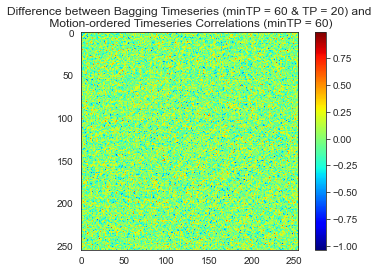

In [184]:
diff_ordered_bagging = bootstrap_minTP_correlations-motion_ordered_correlations
plt.imshow(diff_ordered_bagging, cmap = 'jet')
plt.title('Difference between Bagging Timeseries (minTP = 60 & TP = 20) and\n Motion-ordered Timeseries Correlations (minTP = 60)')
plt.colorbar()


In [185]:
np.abs(diff_ordered_bagging[np.tril_indices(diff_ordered_bagging.shape[0], k = -1)]).mean()

0.2114033190962889

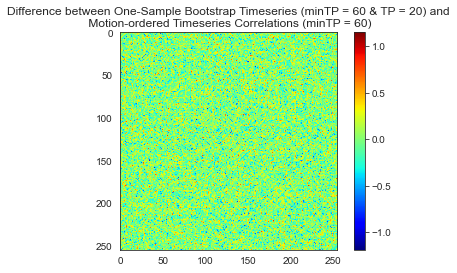

In [188]:
diff_ordered_onesample = bootstrap_minTP_correlations-one_sample_bootstrap_minTP_correlations
plt.imshow(diff_ordered_onesample, cmap = 'jet')
plt.title('Difference between One-Sample Bootstrap Timeseries (minTP = 60 & TP = 20) and\n Motion-ordered Timeseries Correlations (minTP = 60)')
plt.colorbar()


In [189]:
np.abs(diff_ordered_onesample[np.tril_indices(diff_ordered_onesample.shape[0], k = -1)]).mean()

0.2616767802068206

#### Testing Epoch for Bagging: No iteration [only minTP]

In [337]:
subjects = 379
epochs = 500

all_samples_REST1 = []
all_samples_REST2 = []

bootstrap_REST1 = np.zeros((epochs, subjects))
bootstrap_REST2 = np.zeros((epochs, subjects))

edges = ((rsfMRI_bestroi_nonzero_bag_timeseries.shape[1]**2 - rsfMRI_bestroi_nonzero_bag_timeseries.shape[1])) // 2

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
    bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
    all_samples_REST1.append(samples)
    
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    
    for subREST1 in range(bootstrap_samples_REST1.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST1
        subREST1_RMSFD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
        remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
        top_bootstrap_samples_REST1 = np.take(bootstrap_samples_REST1, find_indices_best_motion_REST1, axis = 2)
        rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, :, :]
        
        #randomly select X amount of timepoints from the top timepoints for each participant
        bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], TP, replace = True)
        bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
        bootstrap_corr_matrix = np.corrcoef(rsfMRI_bootstrap_timeseries_2d)
            
        bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
        arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
        trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
        bootstrap_REST1[epoch, subREST1] = trunc_bootstrap_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

We then use the bagged FC matrices and compute the relationships with the phenotypic data for each epoch. We retain the correlation coefficient and significance of the relationship for each epoch in order to help us plot these as a function of N. Further, we compute and plot the following in a singe graph: (I) minimum coefficient; (II) maximum coefficient; (III) mean coefficient; (IV) lower 95% CI; and (V) upper 95% CI.

In [338]:
model_bagging_pval = []
model_bagging_coef = []

behav_bag = behav_df[['AGE', 'SEX', 'REST1_FD']]
behav_bag = pd.DataFrame(np.delete(np.array(behav_bag), unique_subj_exclusion, axis = 0))

for epoch in range(epochs):
    
    behav_bag_samples = pd.DataFrame(np.take(np.array(behav_bag), all_samples_REST1[epoch], axis = 0))
    behav_bag_samples.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav_bag_samples['FC'] = bootstrap_REST1[epoch, :]
    
    bagging_model = pg.partial_corr(data = behav_bag_samples, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_bagging_pval.append(bagging_model['p-val'])
    model_bagging_coef.append(bagging_model['r'])
    

In [339]:
model_bagging_pval = np.array(model_bagging_pval)
model_bagging_coef = np.array(model_bagging_coef)

min_coef = model_bagging_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_bagging_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_bagging_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_bagging_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_bagging_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.23710529622208557
max coef:0.23710529622208557
mean coef:0.2371052962220856
lower ci:0.23710529622208557
upper ci:0.23710529622208557


In [96]:
bagging_approach_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'bag_REST1_FD02_minTR60_TR20_EP1')
bagging_approach_REST.head(n = 10)


,SAMPLES,SIZE,MINTR,FD,METHOD,COEFFICIENTS
0,20,255,60,0.2,MIN,-0.490
1,40,255,60,0.2,MIN,-0.320
2,60,255,60,0.2,MIN,-0.100
3,80,255,60,0.2,MIN,-0.012
4,100,255,60,0.2,MIN,-0.018
5,120,255,60,0.2,MIN,0.042
6,140,255,60,0.2,MIN,0.086
7,160,255,60,0.2,MIN,0.100
8,180,255,60,0.2,MIN,0.051
9,200,255,60,0.2,MIN,0.090


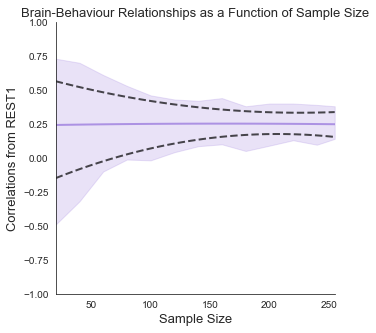

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

plt.xlim(bagging_approach_REST["SAMPLES"].min(), bagging_approach_REST["SAMPLES"].max())
plt.xlim(20, 255)

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(bagging_approach_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["mediumpurple", "mediumpurple", "mediumpurple", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = bagging_approach_REST.loc[bagging_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(bagging_approach_REST["SAMPLES"].unique(), bagging_approach_REST[bagging_approach_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 bagging_approach_REST[bagging_approach_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color = 'mediumpurple', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST1", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


#### Compare standard approach vs. bagging approach

In [140]:
compare_approach_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_scrubbing.xlsx', sheet_name = 'compare_scrub_bag_N255')
compare_approach_REST.head(n = 10)


,SAMPLES,METHOD,COEFFICIENTS
0,20,bagging_LCI,-0.1500
1,40,bagging_LCI,0.0039
2,60,bagging_LCI,0.1000
3,80,bagging_LCI,0.1200
4,100,bagging_LCI,0.1900
5,120,bagging_LCI,0.2000
6,140,bagging_LCI,0.2100
7,160,bagging_LCI,0.2400
8,180,bagging_LCI,0.2500
9,200,bagging_LCI,0.2600


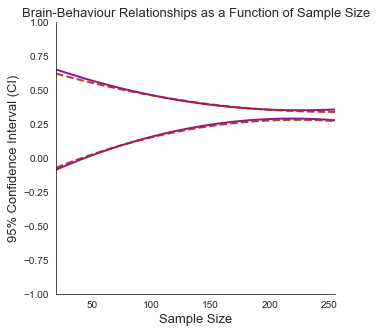

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 255)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(compare_approach_REST["METHOD"].unique(), ["-", "--", "-", "--"], ["purple", "firebrick", "purple", "firebrick"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = compare_approach_REST.loc[compare_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.9}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.xlabel("Sample Size", size = 13)
plt.ylabel("95% Confidence Interval (CI)", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()



In [79]:
compare_approach_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'bag_N255_minTP60TP20_Noepoch')
compare_approach_REST.head(n = 10)


ImportError: Pandas requires version '3.0.7' or newer of 'openpyxl' (version '3.0.5' currently installed).

In [146]:
from sklearn import metrics

Xbagging_LCI = compare_approach_REST['SAMPLES'][compare_approach_REST['METHOD'] == 'LCI']
Ybagging_LCI = compare_approach_REST['COEFFICIENTS'][compare_approach_REST['METHOD'] == 'LCI']
AUCbagging_LCI = metrics.auc(Xbagging_LCI, Ybagging_LCI)

Xbagging_UCI = compare_approach_REST['SAMPLES'][compare_approach_REST['METHOD'] == 'UCI']
Ybagging_UCI = compare_approach_REST['COEFFICIENTS'][compare_approach_REST['METHOD'] == 'UCI']
AUCbagging_UCI = metrics.auc(Xbagging_UCI, Ybagging_UCI)

AUCbagging = AUCbagging_UCI - AUCbagging_LCI

print("AUC for the Bagging Approach:" + str(AUCbagging))


AUC for the Bagging Approach:83.481


In [9]:
compare_approach_REST = pd.read_csv('/Users/jivesh/Desktop/scripts/compare_FD02_minTR60_TP20.csv')
compare_approach_REST.head(n = 10)


,SAMPLES,METHOD,COEFFICIENTS
0,20,bagging_LCI,-0.1500
1,40,bagging_LCI,0.0039
2,60,bagging_LCI,0.1000
3,80,bagging_LCI,0.1200
4,100,bagging_LCI,0.1900
5,120,bagging_LCI,0.2000
6,140,bagging_LCI,0.2100
7,160,bagging_LCI,0.2400
8,180,bagging_LCI,0.2500
9,200,bagging_LCI,0.2600


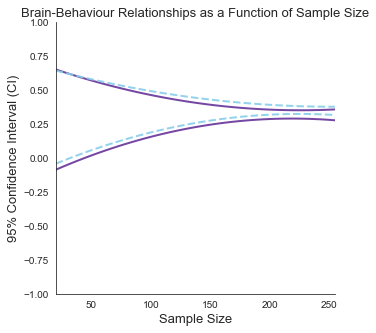

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 255)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(compare_approach_REST["METHOD"].unique(), ["-", "--", "-", "--"], ["rebeccapurple", "skyblue", "rebeccapurple", "skyblue"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = compare_approach_REST.loc[compare_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.9}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.xlabel("Sample Size", size = 13)
plt.ylabel("95% Confidence Interval (CI)", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()

In [13]:
from sklearn import metrics

Xbagging_LCI = compare_approach_REST['SAMPLES'][compare_approach_REST['METHOD'] == 'standard_LCI']
Ybagging_LCI = compare_approach_REST['COEFFICIENTS'][compare_approach_REST['METHOD'] == 'standard_LCI']
AUCbagging_LCI = metrics.auc(Xbagging_LCI, Ybagging_LCI)

Xbagging_UCI = compare_approach_REST['SAMPLES'][compare_approach_REST['METHOD'] == 'standard_UCI']
Ybagging_UCI = compare_approach_REST['COEFFICIENTS'][compare_approach_REST['METHOD'] == 'standard_UCI']
AUCbagging_UCI = metrics.auc(Xbagging_UCI, Ybagging_UCI)

AUCbagging = AUCbagging_UCI - AUCbagging_LCI

print("AUC for the Bagging Approach:" + str(AUCbagging))

AUC for the Bagging Approach:58.37500000000001


#### Plot Bagging Approach for Epoch = 1

In [49]:
bagging_approach_epoch1_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'bag_FD02_REST1_minTR200_TR100E1')
bagging_approach_epoch1_REST.head(n = 10)


,SAMPLES,SIZE,MINTR,FD,METHOD,COEFFICIENTS
0,20,239,200,0.2,MIN,-0.4800
1,40,239,200,0.2,MIN,-0.1200
2,60,239,200,0.2,MIN,0.0073
3,80,239,200,0.2,MIN,-0.0290
4,100,239,200,0.2,MIN,0.1100
5,120,239,200,0.2,MIN,0.1400
6,140,239,200,0.2,MIN,0.1600
7,160,239,200,0.2,MIN,0.1800
8,180,239,200,0.2,MIN,0.1900
9,200,239,200,0.2,MIN,0.2200


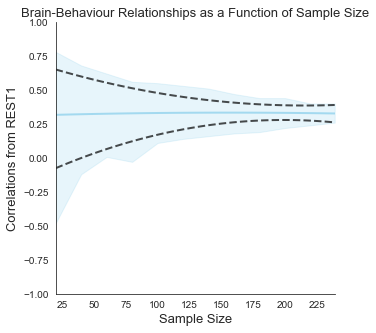

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

plt.xlim(bagging_approach_epoch1_REST["SAMPLES"].min(), bagging_approach_epoch1_REST["SAMPLES"].max())
plt.xlim(20, 239)

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(bagging_approach_epoch1_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["skyblue", "skyblue", "skyblue", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = bagging_approach_epoch1_REST.loc[bagging_approach_epoch1_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(bagging_approach_epoch1_REST["SAMPLES"].unique(), bagging_approach_epoch1_REST[bagging_approach_epoch1_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 bagging_approach_epoch1_REST[bagging_approach_epoch1_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color = 'skyblue', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST1", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


#### Influence of minTP on Brain-Behaviour Relationships

In [55]:
compare_minTP_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'compare_TP_minTR200')
compare_minTP_REST.head(n = 10)


,SAMPLES,SIZE,minTP,TP,LCI,UCI,WIDTH
0,20,239,minTP200,TP20,-0.120,0.68,0.800
1,40,239,minTP200,TP20,0.056,0.59,0.534
2,60,239,minTP200,TP20,0.120,0.55,0.430
3,80,239,minTP200,TP20,0.190,0.51,0.320
4,100,239,minTP200,TP20,0.220,0.48,0.260
5,120,239,minTP200,TP20,0.250,0.46,0.210
6,140,239,minTP200,TP20,0.260,0.45,0.190
7,160,239,minTP200,TP20,0.280,0.43,0.150
8,180,239,minTP200,TP20,0.300,0.42,0.120
9,200,239,minTP200,TP20,0.310,0.41,0.100


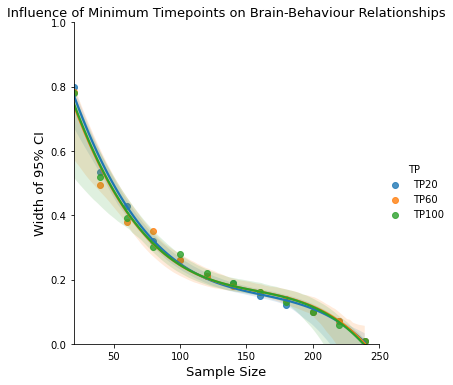

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x="SAMPLES", y="WIDTH", hue="TP", data=compare_minTP_REST, order = 3)
plt.xlim(20,250)
plt.ylim(0, 1)

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Width of 95% CI", size = 13)
plt.title("Influence of Minimum Timepoints on Brain-Behaviour Relationships", size = 13)
sns.despine()


#### Functional Connectome Fingerprinting

##### Standard

In [342]:
trans_FC_REST1 = np.transpose(FC_REST1)
trans_FC_REST2 = np.transpose(FC_REST2)

trans_rsfMRI_corr = (trans_FC_REST1 - trans_FC_REST1.mean(axis = 0)) / trans_FC_REST1.std(axis = 0)
trans_mvfMRI_corr = (trans_FC_REST2 - trans_FC_REST2.mean(axis = 0)) / trans_FC_REST2.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)
max_corr = np.amax(rs_mv_corr, axis = 1)
BID = np.greater_equal(diag_corr_matrix, max_corr)

ID_accuracy = np.sum(BID) / (BID.shape)
print(BID)
print("ID Accuracy:" + str(ID_accuracy))


[False  True  True  True False False  True  True  True False False False
 False False False False False False  True False False False  True False
  True False False  True False False  True False  True False  True  True
 False  True False False  True False False False  True False  True False
 False  True False False  True  True False  True False False False  True
  True  True False False False False False False  True False  True False
 False False False False False False False False False False False  True
 False  True False False False False False  True]
ID Accuracy:[0.32608696]


In [340]:
trans_FC_REST1 = np.delete(np.transpose(FC_REST1), unique_subj_exclusion, axis = 1)
trans_FC_REST2 = np.delete(np.transpose(FC_REST2), unique_subj_exclusion, axis = 1)
print(trans_FC_REST1.shape); print(trans_FC_REST2.shape)

trans_rsfMRI_corr = (trans_FC_REST1 - trans_FC_REST1.mean(axis = 0)) / trans_FC_REST1.std(axis = 0)
trans_mvfMRI_corr = (trans_FC_REST2 - trans_FC_REST2.mean(axis = 0)) / trans_FC_REST2.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)
max_corr = np.amax(rs_mv_corr, axis = 1)
BID = np.greater_equal(diag_corr_matrix, max_corr)

ID_accuracy = np.sum(BID) / (BID.shape)
print(BID)
print("ID Accuracy:" + str(ID_accuracy))


(27261, 81)
(27261, 81)
[ True False  True  True False False  True  True False False False False
 False False False False  True False  True False False False False False
  True  True False  True False False  True False  True False  True False
 False False False  True False False False  True False False False  True
  True False False False  True  True False  True False False False  True
 False  True False False False False False False False False False False
 False False  True  True False False  True  True  True]
ID Accuracy:[0.33333333]


In [339]:
FC_REST1.shape

(92, 27261)

##### Bagging

In [463]:
epochs = 500
numTP = 60

edges = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2

bootstrap_REST1 = np.zeros((epochs, rsfMRI_nonzero_best_timeseries.shape[0], edges))
bootstrap_REST2 = np.zeros((epochs, mvfMRI_nonzero_best_timeseries.shape[0], edges))

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
remaining_motion_param_REST2_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)

bootstrap_rsbest_unique_contaminated_indices = np.array(rsbest_unique_contaminated_indices)
bootstrap_mvbest_unique_contaminated_indices = np.array(mvbest_unique_contaminated_indices)


In [464]:
for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")

    for subREST1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST1
        subREST1_RMSFD = remaining_motion_param_REST1_list[subREST1]
        load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
        remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
        
        top_bootstrap_samples_REST1 = np.take(rsfMRI_nonzero_best_timeseries, find_indices_best_motion_REST1, axis = 2)
        rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, :, :]
    
        #randomly select X amount of timepoints from the top timepoints for each participant
        bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], numTP, replace = True)
        bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
        bootstrap_corr_matrix = np.corrcoef(bootstrap_timeseries)
            
        bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
        arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
        trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
        bootstrap_REST1[epoch, subREST1, :] = trunc_bootstrap_corr


Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

In [465]:
average_rsfMRI_corr_matrix = np.mean(bootstrap_REST1, axis = 0)
#np.savetxt('/Users/jivesh/Downloads/average_rsfMRI_corr_matrix.txt', average_rsfMRI_corr_matrix)

In [ ]:
for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    for subREST2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST2
        subREST2_RMSFD = remaining_motion_param_REST2_list[subREST2]
        load_subREST2_RMSFD = np.loadtxt(subREST2_RMSFD)
        remaining_best_motion_REST2 = np.delete(load_subREST2_RMSFD, bootstrap_mvbest_unique_contaminated_indices[subREST2])
        find_indices_best_motion_REST2 = np.argsort(remaining_best_motion_REST2)[:minTP]
        
        top_bootstrap_samples_REST2 = np.take(mvfMRI_nonzero_best_timeseries, find_indices_best_motion_REST2, axis = 2)
        mvfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST2[subREST2, :, :]
    
        #randomly select X amount of timepoints from the top timepoints for each participant
        bootstrap_sample = np.random.choice(mvfMRI_bootstrap_timeseries_2d.shape[1], numTP, replace = True)
        bootstrap_timeseries = np.take(mvfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
        bootstrap_corr_matrix = np.corrcoef(bootstrap_timeseries)
            
        bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
        arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
        trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
        bootstrap_REST2[epoch, subREST2, :] = trunc_bootstrap_corr
    

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 

In [9]:
average_rsfMRI_corr_matrix = np.loadtxt('/Users/jivesh/Downloads/average_rsfMRI_corr_matrix.txt')
#average_rsfMRI_corr_matrix.shape

(251, 35245)

In [329]:
average_rsfMRI_corr_matrix = np.mean(bootstrap_REST1, axis = 0)
average_mvfMRI_corr_matrix = np.mean(bootstrap_REST2, axis = 0)

trans_FC_REST1 = np.transpose(average_rsfMRI_corr_matrix)
trans_FC_REST2 = np.transpose(average_mvfMRI_corr_matrix)

trans_rsfMRI_corr = (trans_FC_REST1 - trans_FC_REST1.mean(axis = 0)) / trans_FC_REST1.std(axis = 0)
trans_mvfMRI_corr = (trans_FC_REST2 - trans_FC_REST2.mean(axis = 0)) / trans_FC_REST2.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)
max_corr = np.amax(rs_mv_corr, axis = 1)
BID = np.greater_equal(diag_corr_matrix, max_corr)

ID_accuracy = np.sum(BID) / (BID.shape)
print(BID)
print("ID Accuracy:" + str(ID_accuracy))


[False False False False False False  True  True False False False False
 False False False False False False False False False False False False
  True  True False False False  True False False  True False False False
 False  True False  True False False False False False  True False  True
  True  True False False  True False False False False False False  True
 False  True False False False False False False False False False False
 False False  True  True False False False False False]
ID Accuracy:[0.20987654]


##### Motion-ordered (only minTP and no iteration)

In [28]:
edges = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2

bootstrap_REST1 = []
bootstrap_REST2 = []
#bootstrap_REST1 = np.zeros((rsfMRI_nonzero_best_timeseries.shape[0], edges))
#bootstrap_REST2 = np.zeros((mvfMRI_nonzero_best_timeseries.shape[0], edges))
minTP = 60

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
remaining_motion_param_REST2_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)

bootstrap_rsbest_unique_contaminated_indices = np.array(rsbest_unique_contaminated_indices)
bootstrap_mvbest_unique_contaminated_indices = np.array(mvbest_unique_contaminated_indices)


In [29]:
for subREST1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):
    
    #find the top X least contaminated timepoints for each participant for REST1
    subREST1_RMSFD = remaining_motion_param_REST1_list[subREST1]
    load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
    remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
    find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)[:minTP]
    
    timeseries = np.delete(rsfMRI_nonzero_best_timeseries[subREST1], bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 1)
    top_bootstrap_samples_REST1 = np.take(timeseries, find_indices_best_motion_REST1, axis = 1)
    rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1
    
    #randomly select X amount of timepoints from the top timepoints for each participant
    #bootstrap_sample = np.random.choice(rsfMRI_bootstrap_timeseries_2d.shape[1], numTP, replace = True)
    #bootstrap_timeseries = np.take(rsfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
    bootstrap_corr_matrix = np.corrcoef(rsfMRI_bootstrap_timeseries_2d)
            
    bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
    arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
    trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
    bootstrap_REST1.append(trunc_bootstrap_corr)


In [30]:
for subREST2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):
    
    #find the top X least contaminated timepoints for each participant for REST2
    subREST2_RMSFD = remaining_motion_param_REST2_list[subREST2]
    load_subREST2_RMSFD = np.loadtxt(subREST2_RMSFD)
    remaining_best_motion_REST2 = np.delete(load_subREST2_RMSFD, bootstrap_mvbest_unique_contaminated_indices[subREST2])
    find_indices_best_motion_REST2 = np.argsort(remaining_best_motion_REST2)[:minTP]
    
    timeseries = np.delete(mvfMRI_nonzero_best_timeseries[subREST2], bootstrap_mvbest_unique_contaminated_indices[subREST2], axis = 1)
    top_bootstrap_samples_REST2 = np.take(timeseries, find_indices_best_motion_REST2, axis = 1)
    mvfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST2
    
    #randomly select X amount of timepoints from the top timepoints for each participant
    #bootstrap_sample = np.random.choice(mvfMRI_bootstrap_timeseries_2d.shape[1], numTP, replace = True)
    #bootstrap_timeseries = np.take(mvfMRI_bootstrap_timeseries_2d, bootstrap_sample, axis = 1)
    bootstrap_corr_matrix = np.corrcoef(mvfMRI_bootstrap_timeseries_2d)
            
    bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
    arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
    trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
    bootstrap_REST2.append(trunc_bootstrap_corr)
    

In [33]:
trans_FC_REST1 = np.transpose(bootstrap_REST1)
trans_FC_REST2 = np.transpose(bootstrap_REST2)

trans_rsfMRI_corr = (trans_FC_REST1 - trans_FC_REST1.mean(axis = 0)) / trans_FC_REST1.std(axis = 0)
trans_mvfMRI_corr = (trans_FC_REST2 - trans_FC_REST2.mean(axis = 0)) / trans_FC_REST2.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)
max_corr = np.amax(rs_mv_corr, axis = 1)
BID = np.greater_equal(diag_corr_matrix, max_corr)

ID_accuracy = np.sum(BID) / (BID.shape)
print(BID)
print("ID Accuracy:" + str(ID_accuracy))


[False  True  True False  True  True False False False  True False  True
  True False False  True  True False  True False False  True False False
 False  True  True  True False  True  True False  True  True  True  True
  True  True  True False False  True  True  True  True  True  True False
  True  True False False  True  True False  True  True  True False  True
  True  True  True  True False False False  True  True  True  True  True
 False  True False  True False False False False  True False False  True
 False  True  True  True False False  True  True  True  True  True  True
 False False  True  True False False False False False  True False  True
 False  True  True False  True False  True False False False  True False
 False  True  True  True  True  True  True  True False  True  True  True
 False  True False False False  True False  True  True False False False
 False  True  True False False  True  True False False False False False
 False False False  True  True  True False False  T

##### Plot the impact of bagging on fingerprint accuracy

In [2]:
import pandas as pd
fingerprint_REST = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'fingerprint_N77')
fingerprint_REST.head(n = 10)


/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

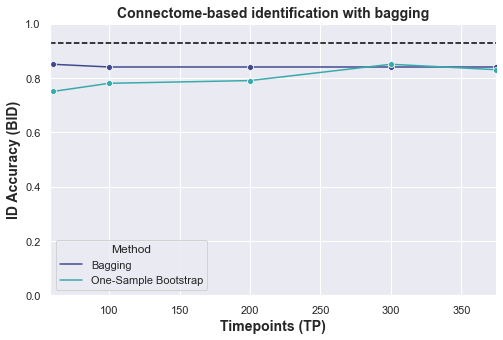

In [76]:
import seaborn as sns

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

plt.figure(figsize = (8, 5))
plt.xlim(58, 375)
plt.ylim(0, 1)

sns.lineplot(data = fingerprint_REST, x = 'numTP', y = 'ID', hue = 'Method', marker = 'o', palette = 'mako')
plt.axhline(0.93, ls = '--', c = 'black')
plt.title('Impact of Bagging on Fingerprint Accuracy', fontsize = 14)
plt.xlabel('Timepoints (TP)', fontsize = 14, fontweight = 'bold')
plt.ylabel('ID Accuracy (BID)', fontsize = 14, fontweight = 'bold')
plt.title("Connectome-based identification with bagging", fontsize = 14, fontweight='bold')

sns.despine()


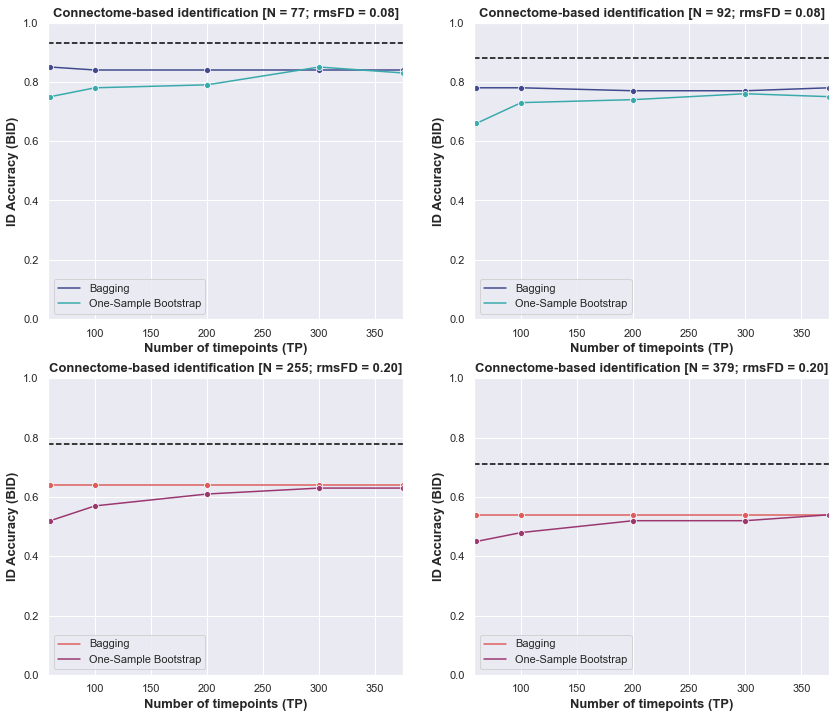

In [29]:
fingerprint_REST1 = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'fingerprint_N77')
fingerprint_REST2 = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'fingerprint_N92')
fingerprint_REST3 = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'fingerprint_N255')
fingerprint_REST4 = pd.read_excel('/Users/jivesh/Desktop/scripts/bootstrap_results_20220310.xlsx', sheet_name = 'fingerprint_N379')

import seaborn as sns
import matplotlib as mpl

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (14,12))
ax1 = sns.lineplot(ax = axs[0,0], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST1, palette = 'mako', marker = 'o')
ax1.axhline(0.93, ls = '--', c = 'black')
ax2 = sns.lineplot(ax = axs[0,1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST2, palette = 'mako', marker = 'o')
ax2.axhline(0.88, ls = '--', c = 'black')
ax3 = sns.lineplot(ax = axs[1,0], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST3, palette = 'flare', marker = 'o')
ax3.axhline(0.78, ls = '--', c = 'black')
ax4 = sns.lineplot(ax = axs[1,1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST4, palette = 'flare', marker = 'o')
ax4.axhline(0.71, ls = '--', c = 'black')

ax1.set_xlim(58,375); ax1.set_ylim(0,1); ax1.legend(loc = 'lower left')
ax2.set_xlim(58,375); ax2.set_ylim(0,1); ax2.legend(loc = 'lower left')
ax3.set_xlim(58,375); ax3.set_ylim(0,1); ax3.legend(loc = 'lower left')
ax4.set_xlim(58,375); ax4.set_ylim(0,1); ax4.legend(loc = 'lower left')

ax1.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax1.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax2.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax3.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax3.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax4.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax4.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')

ax1.set_title("Connectome-based identification [N = 77; rmsFD = 0.08]", fontsize = 13, fontweight = 'bold')
ax2.set_title("Connectome-based identification [N = 92; rmsFD = 0.08]", fontsize = 13, fontweight = 'bold')
ax3.set_title("Connectome-based identification [N = 255; rmsFD = 0.20]", fontsize = 13, fontweight = 'bold')
ax4.set_title("Connectome-based identification [N = 379; rmsFD = 0.20]", fontsize = 13, fontweight = 'bold')

#plt.rcParams["font.weight"] = "bold"; plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14


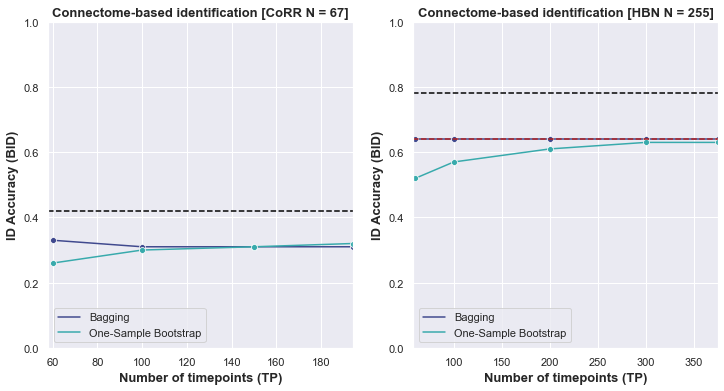

In [448]:
fingerprint_REST1 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_UPSM_N67.csv')
fingerprint_REST2 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_N255.csv')

import seaborn as sns
import matplotlib as mpl

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))
ax1 = sns.lineplot(ax = axs[0], x = "numTP", y = "IDRate", hue = "Method", data = fingerprint_REST1, palette = 'mako', marker = 'o')
ax1.axhline(0.42, ls = '--', c = 'black')
ax2 = sns.lineplot(ax = axs[1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST2, palette = 'mako', marker = 'o')
ax2.axhline(0.78, ls = '--', c = 'black')
ax2.axhline(0.64, ls = '--', c = 'firebrick')

ax1.set_xlim(58,194); ax1.set_ylim(0,1); ax1.legend(loc = 'lower left')
ax2.set_xlim(58,375); ax2.set_ylim(0,1); ax2.legend(loc = 'lower left')

ax1.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax1.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax2.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')

ax1.set_title("Connectome-based identification [CoRR N = 67]", fontsize = 13, fontweight = 'bold')
ax2.set_title("Connectome-based identification [HBN N = 255]", fontsize = 13, fontweight = 'bold')

#plt.rcParams["font.weight"] = "bold"; plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

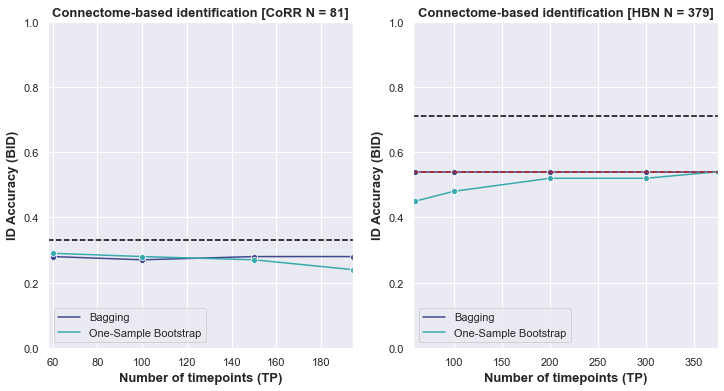

In [445]:
fingerprint_REST1 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_UPSM_N81.csv')
fingerprint_REST2 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_N379.csv')

import seaborn as sns
import matplotlib as mpl

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))
ax1 = sns.lineplot(ax = axs[0], x = "numTP", y = "IDRate", hue = "Method", data = fingerprint_REST1, palette = 'mako', marker = 'o')
ax1.axhline(0.33, ls = '--', c = 'black')
ax2 = sns.lineplot(ax = axs[1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST2, palette = 'mako', marker = 'o')
ax2.axhline(0.71, ls = '--', c = 'black')
ax2.axhline(0.54, ls = '--', c = 'firebrick')

ax1.set_xlim(58,194); ax1.set_ylim(0,1); ax1.legend(loc = 'lower left')
ax2.set_xlim(58,375); ax2.set_ylim(0,1); ax2.legend(loc = 'lower left')

ax1.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax1.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax2.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')

ax1.set_title("Connectome-based identification [CoRR N = 81]", fontsize = 13, fontweight = 'bold')
ax2.set_title("Connectome-based identification [HBN N = 379]", fontsize = 13, fontweight = 'bold')

#plt.rcParams["font.weight"] = "bold"; plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

#### Scrubbing Approach (No bagging invovled)

In [801]:
subjects = 379
epochs = 500

all_samples_REST1 = []
all_samples_REST2 = []

bootstrap_REST1 = np.zeros((epochs, subjects))
bootstrap_REST2 = np.zeros((epochs, subjects))

edges = ((rsfMRI_bestroi_nonzero_bag_timeseries.shape[1]**2 - rsfMRI_bestroi_nonzero_bag_timeseries.shape[1])) // 2

remaining_motion_param_REST1_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)

for epoch in range(epochs):
    
    if epoch == 0:
        print("Doing epoch {} of {}...".format(epoch + 1, epochs), end = " ")
        
    else:
        print("{}..".format(epoch + 1), end = " ")
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_bag_timeseries.shape[0], subjects, replace = False)
    bootstrap_samples_REST1 = np.take(rsfMRI_bestroi_nonzero_bag_timeseries, samples, axis = 0)
    all_samples_REST1.append(samples)
    
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
    remaining_motion_param_REST1_sample = np.take(remaining_motion_param_REST1_list, samples)
    
    for subREST1 in range(bootstrap_samples_REST1.shape[0]):
        
        #find the top X least contaminated timepoints for each participant for REST1
        subREST1_RMSFD = remaining_motion_param_REST1_sample[subREST1]
        load_subREST1_RMSFD = np.loadtxt(subREST1_RMSFD)
        remaining_best_motion_REST1 = np.delete(load_subREST1_RMSFD, bootstrap_rsbest_unique_contaminated_indices[subREST1])
        
        find_indices_best_motion_REST1 = np.argsort(remaining_best_motion_REST1)#[:minTP]
        #find_indices_best_motion_REST1 = np.argwhere(remaining_best_motion_REST1).squeeze()
        timeseries =  np.delete(bootstrap_samples_REST1, bootstrap_rsbest_unique_contaminated_indices[subREST1], axis = 2)
        
        #top_bootstrap_samples_REST1 = np.take(bootstrap_samples_REST1, find_indices_best_motion_REST1, axis = 2)
        top_bootstrap_samples_REST1 = np.take(timeseries, find_indices_best_motion_REST1, axis = 2)
        rsfMRI_bootstrap_timeseries_2d = top_bootstrap_samples_REST1[subREST1, :, :]
        
        bootstrap_corr_matrix = np.corrcoef(rsfMRI_bootstrap_timeseries_2d)
            
        bootstrap_corr_shen = bootstrap_corr_matrix.shape[0]
        arange_bootstrap_corr, diag = np.triu_indices(bootstrap_corr_shen, 1)
        trunc_bootstrap_corr = bootstrap_corr_matrix[arange_bootstrap_corr, diag]
        
        bootstrap_REST1[epoch, subREST1] = trunc_bootstrap_corr
        

Doing epoch 1 of 500... 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 18

In [802]:
model_bagging_pval = []
model_bagging_coef = []

behav_bag = behav_df[['AGE', 'SEX', 'REST1_FD']]
behav_bag = pd.DataFrame(np.delete(np.array(behav_bag), unique_subj_exclusion, axis = 0))

for epoch in range(epochs):
    
    behav_bag_samples = pd.DataFrame(np.take(np.array(behav_bag), all_samples_REST1[epoch], axis = 0))
    behav_bag_samples.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav_bag_samples['FC'] = bootstrap_REST1[epoch, :]
    
    bagging_model = pg.partial_corr(data = behav_bag_samples, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_bagging_pval.append(bagging_model['p-val'])
    model_bagging_coef.append(bagging_model['r'])
    

In [803]:
model_bagging_pval = np.array(model_bagging_pval)
model_bagging_coef = np.array(model_bagging_coef)

min_coef = model_bagging_coef.min()
print("min coef:" + str(min_coef))

max_coef = model_bagging_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model_bagging_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model_bagging_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model_bagging_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.29424087924296227
max coef:0.29424087924296227
mean coef:0.29424087924296227
lower ci:0.29424087924296227
upper ci:0.29424087924296227


In [874]:
bagging_approach_REST = pd.read_csv('/Users/jivesh/Downloads/motionorder.csv')
bagging_approach_REST.head(n = 10)


,SAMPLES,SIZE,MINTR,FD,METHOD,COEFFICIENTS
0,20,379,60,0.2,MIN,-0.560
1,60,379,60,0.2,MIN,-0.091
2,100,379,60,0.2,MIN,-0.019
3,140,379,60,0.2,MIN,0.063
4,180,379,60,0.2,MIN,0.057
5,220,379,60,0.2,MIN,0.130
6,260,379,60,0.2,MIN,0.150
7,300,379,60,0.2,MIN,0.170
8,340,379,60,0.2,MIN,0.200
9,379,379,60,0.2,MIN,0.240


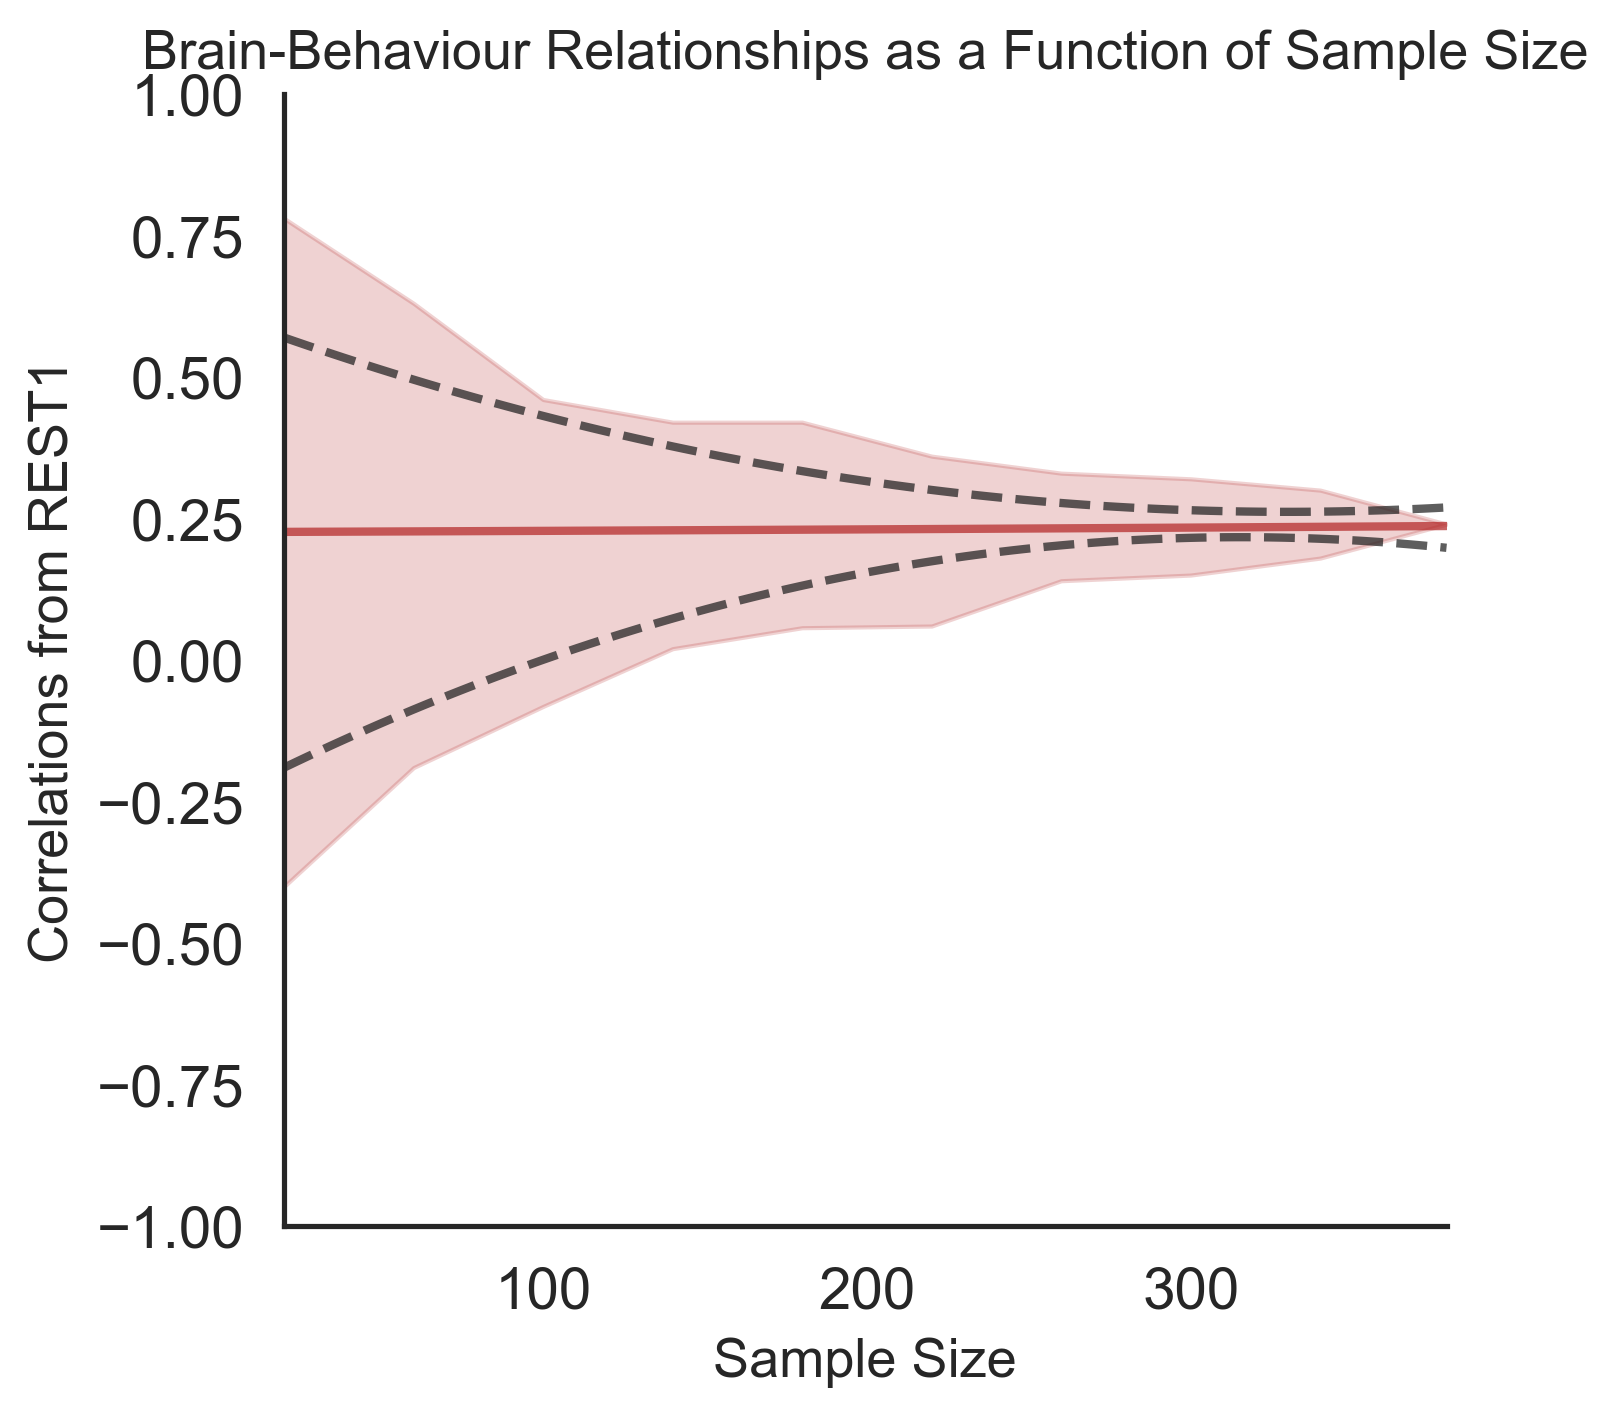

In [867]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

plt.xlim(bagging_approach_REST["SAMPLES"].min(), bagging_approach_REST["SAMPLES"].max())
plt.xlim(20, 379)

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(bagging_approach_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["firebrick", "firebrick", "firebrick", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = bagging_approach_REST.loc[bagging_approach_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(bagging_approach_REST["SAMPLES"].unique(), bagging_approach_REST[bagging_approach_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 bagging_approach_REST[bagging_approach_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color = 'firebrick', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST1", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


In [875]:
from sklearn import metrics

Xbagging_LCI = bagging_approach_REST['SAMPLES'][bagging_approach_REST['METHOD'] == 'LCI']
Ybagging_LCI = bagging_approach_REST['COEFFICIENTS'][bagging_approach_REST['METHOD'] == 'LCI']
AUCbagging_LCI = metrics.auc(Xbagging_LCI, Ybagging_LCI)

Xbagging_UCI = bagging_approach_REST['SAMPLES'][bagging_approach_REST['METHOD'] == 'UCI']
Ybagging_UCI = bagging_approach_REST['COEFFICIENTS'][bagging_approach_REST['METHOD'] == 'UCI']
AUCbagging_UCI = metrics.auc(Xbagging_UCI, Ybagging_UCI)

AUCbagging = AUCbagging_UCI - AUCbagging_LCI

print("AUC for the Bagging Approach:" + str(AUCbagging))


AUC for the Bagging Approach:84.24000000000001


In [178]:
rs_motion_param_datapath = '/Users/jivesh/Downloads/HBN_MOTION_N379/*_task-rest_run-1_bold_mcf.nii.gz_rel.rms'
mv_motion_param_datapath = '/Users/jivesh/Downloads/HBN_MOTION_N379/*_task-rest_run-2_bold_mcf.nii.gz_rel.rms'

rsfilename_motion_param_list = np.sort(glob.glob(rs_motion_param_datapath))
mvfilename_motion_param_list = np.sort(glob.glob(mv_motion_param_datapath))

rssubj_exclusion = []
mvsubj_exclusion = []
best_timepoints_size_s1 = []
best_timepoints_size_s2 = []
all_unique_contaminated_indices = []
rsall_unique_contaminated_indices = []
mvall_unique_contaminated_indices = []

#select head motion threshold to identify contaminated timepoints
threshold = 0.20

#select a minimum amount of timepoints to be retained after identifying contaminated timepoints
mintimepoint = 20


In [179]:
for rsfilename in range(rsfMRI_nonzero_timeseries.shape[0]):

    #load each subject's head motion parameter files for Session 1
    rmsFDs1 = np.loadtxt(rsfilename_motion_param_list[rsfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs1_thresh = np.asarray(np.where(rmsFDs1 > threshold))

    #find the indices of the preceding timepoints to be srubbed from the timeseries
    left_indices = rmsFDs1_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    left_nonzero_indices = left_indices[left_indices >= 0]
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    right_first_indices = rmsFDs1_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    right_first_in_range_indices = right_first_indices[right_first_indices < rmsFDs1.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    right_second_indices = rmsFDs1_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    right_second_in_range_indices = right_second_indices[right_second_indices < rmsFDs1.shape]

    #concatenate all the contaminated indices including the scrubbed indices into an array
    all_contaminated_indices = np.concatenate((rmsFDs1_thresh, left_nonzero_indices, right_first_in_range_indices, right_second_in_range_indices), axis = None)
    #find all the unique contaminated indices including the scrubbed indices
    unique_contaminated_indices = np.unique(all_contaminated_indices).astype(int)
    #append all subjects' unique contaminated indices including the scrubbed indices into an array
    all_unique_contaminated_indices.append(unique_contaminated_indices)

    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_timepoints_size = rsfMRI_nonzero_timeseries.shape[2] - np.asarray(unique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints left in an array
    best_timepoints_size_s1.append(best_timepoints_size)

    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints required
    if (best_timepoints_size < mintimepoint):
        rssubj_exclusion.append(rsfilename)

print(np.array(rssubj_exclusion).shape[0])


0


In [180]:
for mvfilename in range(mvfMRI_nonzero_timeseries.shape[0]):

    #load each subject's head motion parameter files for Session 2
    rmsFDs2 = np.loadtxt(mvfilename_motion_param_list[mvfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs2_thresh = np.asarray(np.where(rmsFDs2 > threshold))

    #find the indices of the preceding timepoints to be srubbed from the timeseries
    mvleft_indices = rmsFDs2_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    mvleft_nonzero_indices = mvleft_indices[mvleft_indices >= 0]
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    mvright_first_indices = rmsFDs2_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    mvright_first_in_range_indices = mvright_first_indices[mvright_first_indices < rmsFDs2.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    mvright_second_indices = rmsFDs2_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    mvright_second_in_range_indices = mvright_second_indices[mvright_second_indices < rmsFDs2.shape]

    #concatenate all the contaminated indices including the scrubbed indices into an array
    mvall_contaminated_indices = np.concatenate((rmsFDs2_thresh, mvleft_nonzero_indices, mvright_first_in_range_indices, mvright_second_in_range_indices), axis = None)
    #find all the unique contaminated indices including the scrubbed indices
    mvunique_contaminated_indices = np.unique(mvall_contaminated_indices).astype(int)
    #append all subjects' unique contaminated indices including the scrubbed indices into an array
    mvall_unique_contaminated_indices.append(mvunique_contaminated_indices)

    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_mvtimepoints_size = mvfMRI_nonzero_timeseries.shape[2] - np.asarray(mvunique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints left in an array
    best_timepoints_size_s2.append(best_mvtimepoints_size)

    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints required
    if (best_mvtimepoints_size < mintimepoint):
        mvsubj_exclusion.append(mvfilename)

print(np.array(mvsubj_exclusion).shape[0])


0


In [181]:
#concatenate all subjects to be excluded from Session 1 & Session 2
all_subj_exclusion = np.concatenate((rssubj_exclusion, mvsubj_exclusion), axis = None)
#find the unique subjects to be excluded from Session 1 & Session 2
unique_subj_exclusion = np.unique(all_subj_exclusion).astype(int)

#remove the size of the best timepoints for the subjects to be excluded for Session 1 & Session 2
best_timepoints_s1 = np.delete(best_timepoints_size_s1, unique_subj_exclusion)
best_timepoints_s2 = np.delete(best_timepoints_size_s2, unique_subj_exclusion)
print(best_timepoints_s1.shape[0]); print(best_timepoints_s2.shape[0])

#remove the subjects to be excluded from the original 3D array for Session 1 & Session 2
rsfMRI_nonzero_best_timeseries = np.delete(rsfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
mvfMRI_nonzero_best_timeseries = np.delete(mvfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
print(rsfMRI_nonzero_best_timeseries.shape); print(mvfMRI_nonzero_best_timeseries.shape)

#remove all the unique contaminated indices of the subjects to be excluded for Session 1 & Session 2
rsbest_unique_contaminated_indices = np.delete(all_unique_contaminated_indices, unique_subj_exclusion)
mvbest_unique_contaminated_indices = np.delete(mvall_unique_contaminated_indices, unique_subj_exclusion)
print(rsbest_unique_contaminated_indices.shape[0]); print(mvbest_unique_contaminated_indices.shape[0])


379
379
(379, 200, 375)
(379, 200, 375)
379
379


In [182]:
for subREST1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):
    
    rsname = subREST1 + 1
    scrubbed_rsfMRI_timeseries = np.delete(rsfMRI_nonzero_best_timeseries, rsbest_unique_contaminated_indices[subREST1], axis = 2)
    print(scrubbed_rsfMRI_timeseries.shape)
    scrubbed_REST1_FC_matrix = np.corrcoef(scrubbed_rsfMRI_timeseries[subREST1, :, :])
    pd.DataFrame(scrubbed_REST1_FC_matrix).to_csv(f"/Users/jivesh/Downloads/REST1_N379/00{rsname}.csv", header = None, index = None)


(379, 200, 287)
(379, 200, 355)
(379, 200, 375)
(379, 200, 336)
(379, 200, 265)
(379, 200, 253)
(379, 200, 326)
(379, 200, 286)
(379, 200, 131)
(379, 200, 296)
(379, 200, 82)
(379, 200, 115)
(379, 200, 220)
(379, 200, 309)
(379, 200, 263)
(379, 200, 371)
(379, 200, 276)
(379, 200, 273)
(379, 200, 332)
(379, 200, 97)
(379, 200, 180)
(379, 200, 225)
(379, 200, 181)
(379, 200, 144)
(379, 200, 294)
(379, 200, 215)
(379, 200, 367)
(379, 200, 348)
(379, 200, 338)
(379, 200, 360)
(379, 200, 313)
(379, 200, 197)
(379, 200, 356)
(379, 200, 375)
(379, 200, 341)
(379, 200, 268)
(379, 200, 355)
(379, 200, 210)
(379, 200, 324)
(379, 200, 375)
(379, 200, 352)
(379, 200, 286)
(379, 200, 330)
(379, 200, 311)
(379, 200, 246)
(379, 200, 85)
(379, 200, 307)
(379, 200, 310)
(379, 200, 364)
(379, 200, 375)
(379, 200, 362)
(379, 200, 366)
(379, 200, 306)
(379, 200, 159)
(379, 200, 311)
(379, 200, 197)
(379, 200, 289)
(379, 200, 216)
(379, 200, 375)
(379, 200, 267)
(379, 200, 218)
(379, 200, 375)
(379, 200, 

In [183]:
for subREST2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):
    
    mvname = subREST2 + 1
    scrubbed_mvfMRI_timeseries = np.delete(mvfMRI_nonzero_best_timeseries, mvbest_unique_contaminated_indices[subREST2], axis = 2)
    print(scrubbed_mvfMRI_timeseries.shape)
    scrubbed_REST2_FC_matrix = np.corrcoef(scrubbed_mvfMRI_timeseries[subREST2, :, :])
    pd.DataFrame(scrubbed_REST2_FC_matrix).to_csv(f"/Users/jivesh/Downloads/REST2_N379/00{mvname}.csv", header = None, index = None)


(379, 200, 157)
(379, 200, 339)
(379, 200, 375)
(379, 200, 341)
(379, 200, 194)
(379, 200, 189)
(379, 200, 357)
(379, 200, 320)
(379, 200, 85)
(379, 200, 249)
(379, 200, 87)
(379, 200, 201)
(379, 200, 213)
(379, 200, 167)
(379, 200, 360)
(379, 200, 371)
(379, 200, 220)
(379, 200, 314)
(379, 200, 267)
(379, 200, 119)
(379, 200, 264)
(379, 200, 283)
(379, 200, 127)
(379, 200, 74)
(379, 200, 256)
(379, 200, 305)
(379, 200, 354)
(379, 200, 299)
(379, 200, 302)
(379, 200, 340)
(379, 200, 312)
(379, 200, 125)
(379, 200, 356)
(379, 200, 375)
(379, 200, 286)
(379, 200, 322)
(379, 200, 282)
(379, 200, 247)
(379, 200, 330)
(379, 200, 170)
(379, 200, 371)
(379, 200, 283)
(379, 200, 327)
(379, 200, 311)
(379, 200, 241)
(379, 200, 75)
(379, 200, 301)
(379, 200, 332)
(379, 200, 357)
(379, 200, 365)
(379, 200, 344)
(379, 200, 311)
(379, 200, 286)
(379, 200, 102)
(379, 200, 335)
(379, 200, 76)
(379, 200, 330)
(379, 200, 213)
(379, 200, 334)
(379, 200, 273)
(379, 200, 222)
(379, 200, 358)
(379, 200, 36

In [185]:
#input directory for the FC matrices derived from Shen parcellation
rs_datapath = '/Users/jivesh/Downloads/REST2_N379/00*.csv'
mv_datapath = '/Users/jivesh/Downloads/REST1_N379/00*.csv'

rsfilename_list = np.sort(glob.glob(rs_datapath))
mvfilename_list = np.sort(glob.glob(mv_datapath))

rsfMRI_timeseries_corr = []
mvfMRI_timeseries_corr = []

for rsfilename in rsfilename_list:
    rsfMRI_corr = np.array(pd.read_csv(rsfilename, header = None))
    #truncate correlation matrix to select upper triangular matrix for Session 1
    rsfMRI_corr_shen = rsfMRI_corr.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr[arange_rsfMRI_corr, diag]
    
    #append the truncated correlation matrix of all subjects to the list
    rsfMRI_timeseries_corr.append(trunc_rsfMRI_corr_shen)

for mvfilename in mvfilename_list:
    
    mvfMRI_corr = np.array(pd.read_csv(mvfilename, header = None))
    #truncate correlation matrix to select upper triangular matrix for Session 2
    mvfMRI_corr_shen = mvfMRI_corr.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr[arange_mvfMRI_corr, diag]
    
    #append the truncated correlation matrix of all subjects to the list
    mvfMRI_timeseries_corr.append(trunc_mvfMRI_corr_shen)

#convert the list to an array for Session 1 & 2
trunc_rsfMRI_corr_to_array = np.asarray(rsfMRI_timeseries_corr)
trunc_mvfMRI_corr_to_array = np.asarray(mvfMRI_timeseries_corr)

#transpose the array to ease further computation for Session 1 & 2
trans_rsfMRI_corr = np.transpose(trunc_rsfMRI_corr_to_array)
trans_mvfMRI_corr = np.transpose(trunc_mvfMRI_corr_to_array)

#compute columnwise pearson's correlation matrix between Session 1 and Session 2
trans_rsfMRI_corr = (trans_rsfMRI_corr - trans_rsfMRI_corr.mean(axis = 0)) / trans_rsfMRI_corr.std(axis = 0)
trans_mvfMRI_corr = (trans_mvfMRI_corr - trans_mvfMRI_corr.mean(axis = 0)) / trans_mvfMRI_corr.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#extract the diagonal values of the final correlation matrix
diag = np.diag(rs_mv_corr)

#extract the maximum value in each row of the final correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that row in the final correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value of each row to
#allow successful identification
diag_to_array = np.array(diag)
max_corr_to_array = np.array(max_corr)
BID = np.greater_equal(diag_to_array, max_corr_to_array)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
success_rate_BID = np.sum(BID)/(BID.shape)
print(success_rate_BID)


[0.70448549]


In [167]:
(0.75+0.79)/2 #low-motion

0.77

In [187]:
np.round((0.66+0.70)/2,3) #high-motion

0.68

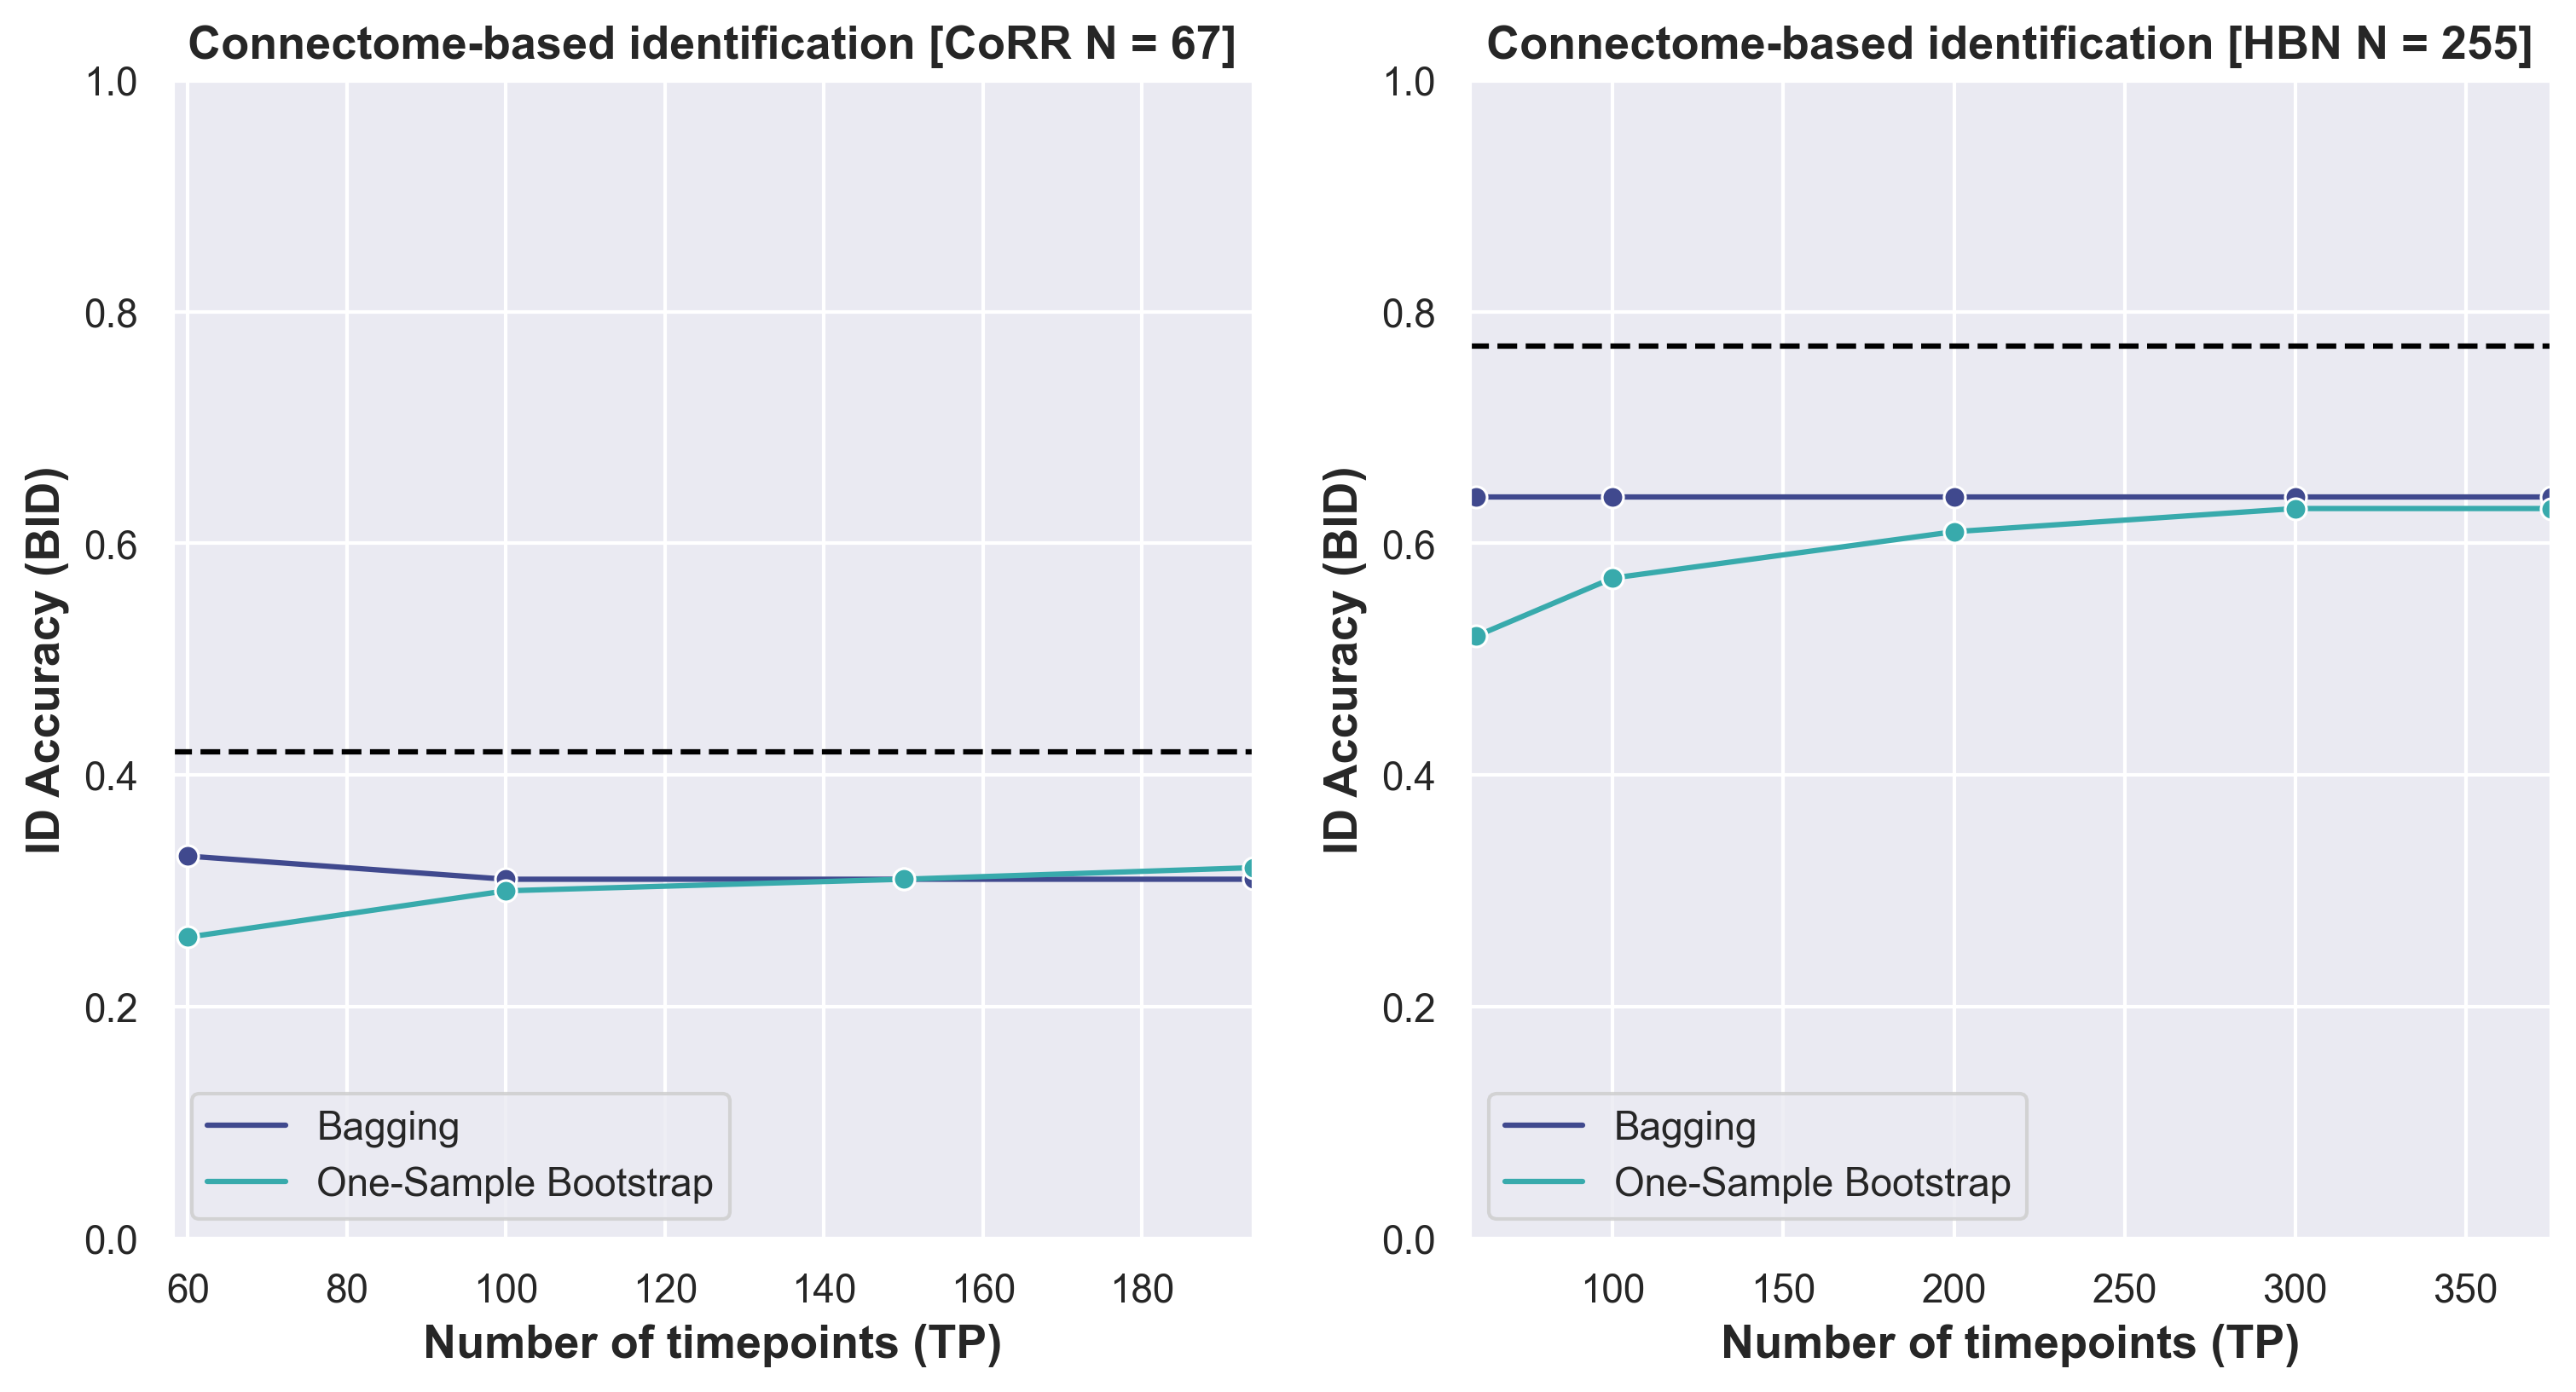

In [192]:
fingerprint_REST1 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_UPSM_N67.csv')
fingerprint_REST2 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_N255.csv')

import seaborn as sns
import matplotlib as mpl

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))
ax1 = sns.lineplot(ax = axs[0], x = "numTP", y = "IDRate", hue = "Method", data = fingerprint_REST1, palette = 'mako', marker = 'o')
ax1.axhline(0.42, ls = '--', c = 'black')
ax2 = sns.lineplot(ax = axs[1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST2, palette = 'mako', marker = 'o')
ax2.axhline(0.77, ls = '--', c = 'black')

ax1.set_xlim(58,194); ax1.set_ylim(0,1); ax1.legend(loc = 'lower left')
ax2.set_xlim(58,375); ax2.set_ylim(0,1); ax2.legend(loc = 'lower left')

ax1.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax1.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax2.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')

ax1.set_title("Connectome-based identification [CoRR N = 67]", fontsize = 13, fontweight = 'bold')
ax2.set_title("Connectome-based identification [HBN N = 255]", fontsize = 13, fontweight = 'bold')

#plt.rcParams["font.weight"] = "bold"; plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

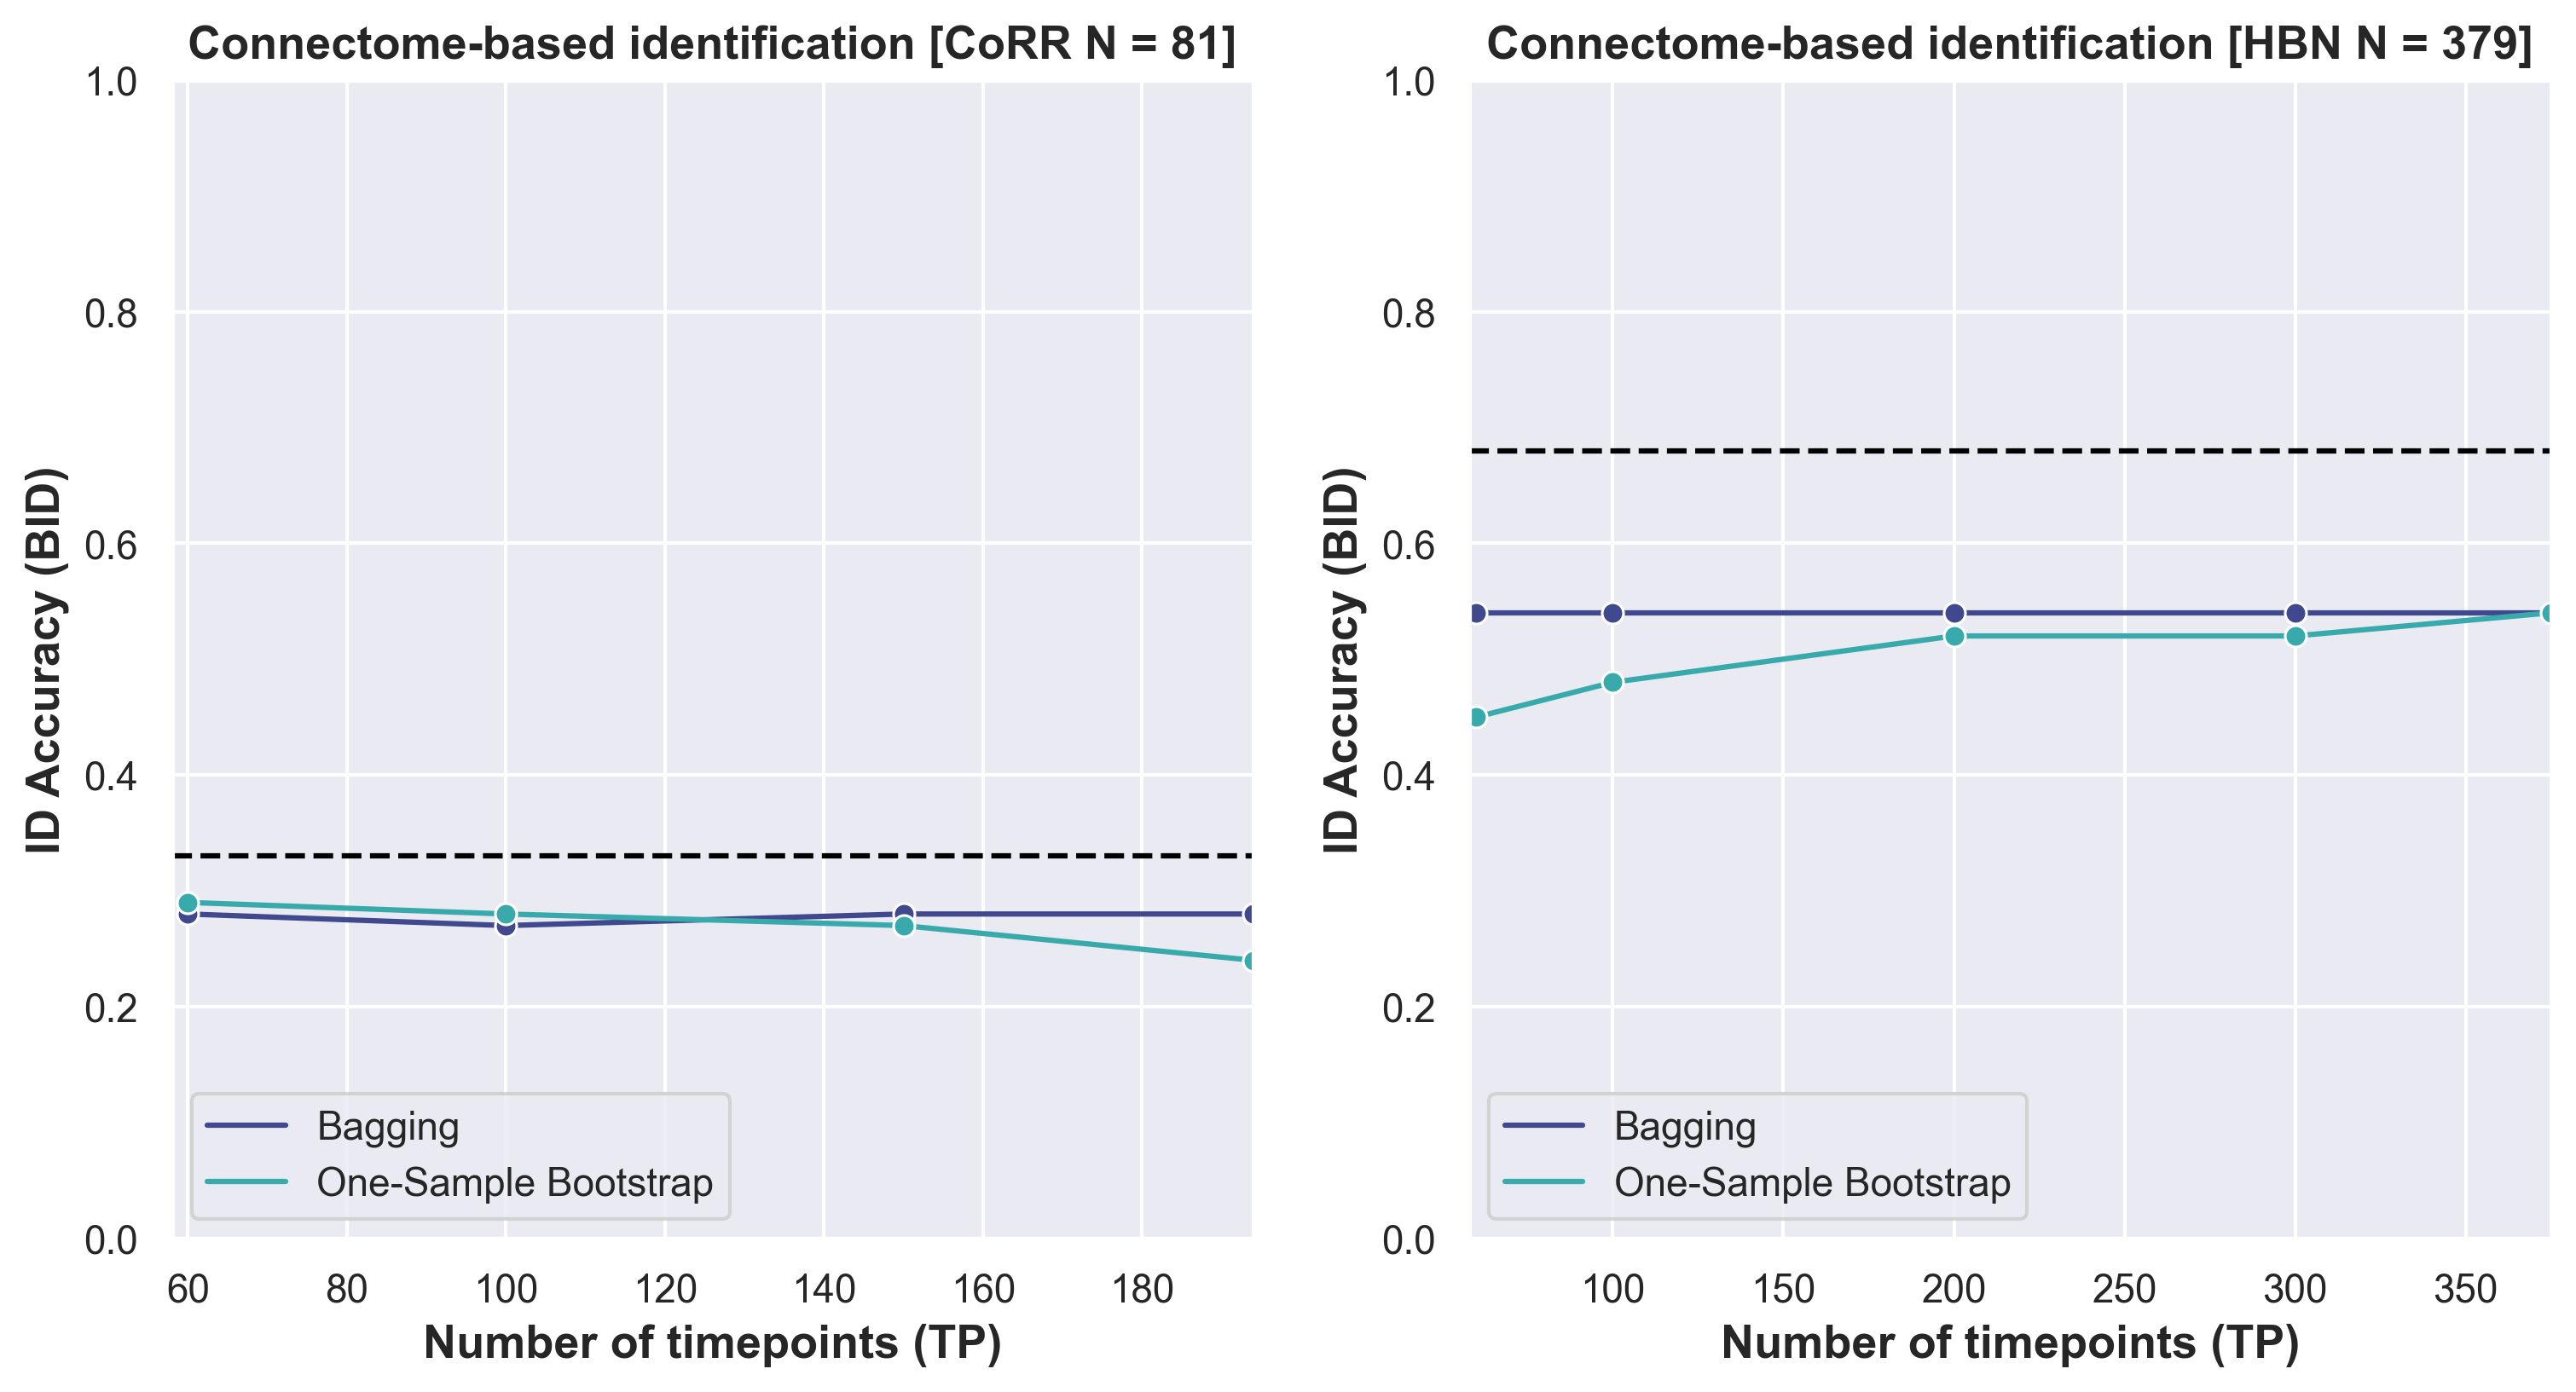

In [193]:
fingerprint_REST1 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_UPSM_N81.csv')
fingerprint_REST2 = pd.read_csv('/Users/jivesh/Desktop/scripts/fingerprint_N379.csv')

import seaborn as sns
import matplotlib as mpl

sns.set(style = 'darkgrid')
mpl.rc('font', family='serif', serif ='Arial')
sns.set_style({'font.family': 'serif'})

plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))
ax1 = sns.lineplot(ax = axs[0], x = "numTP", y = "IDRate", hue = "Method", data = fingerprint_REST1, palette = 'mako', marker = 'o')
ax1.axhline(0.33, ls = '--', c = 'black')
ax2 = sns.lineplot(ax = axs[1], x = "numTP", y = "ID", hue = "Method", data = fingerprint_REST2, palette = 'mako', marker = 'o')
ax2.axhline(0.68, ls = '--', c = 'black')

ax1.set_xlim(58,194); ax1.set_ylim(0,1); ax1.legend(loc = 'lower left')
ax2.set_xlim(58,375); ax2.set_ylim(0,1); ax2.legend(loc = 'lower left')

ax1.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax1.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')
ax2.set_xlabel('Number of timepoints (TP)', fontsize = 13, fontweight = 'bold'); ax2.set_ylabel('ID Accuracy (BID)', fontsize = 13, fontweight = 'bold')

ax1.set_title("Connectome-based identification [CoRR N = 81]", fontsize = 13, fontweight = 'bold')
ax2.set_title("Connectome-based identification [HBN N = 379]", fontsize = 13, fontweight = 'bold')

#plt.rcParams["font.weight"] = "bold"; plt.rcParams["axes.labelweight"] = "bold"

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14